In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import ttest_ind
from matplotlib.ticker import PercentFormatter
from pathlib import Path

In [2]:
# sns.set_theme(style="darkgrid")

# Initial checks and cleaning

In [3]:
DATA_DIR = Path("./data").resolve()

transactions_data = DATA_DIR / "QVI_transaction_data(in).csv"
purchase_behavior_data = DATA_DIR / "QVI_purchase_behaviour.csv"

print(transactions_data.absolute())
print(purchase_behavior_data.absolute())

D:\Users\Esperine\Workspace3\esper-datalab-main\forage_quantium\data\QVI_transaction_data(in).csv
D:\Users\Esperine\Workspace3\esper-datalab-main\forage_quantium\data\QVI_purchase_behaviour.csv


In [4]:
df_trans = pd.read_csv(transactions_data)
df_purc = pd.read_csv(purchase_behavior_data)

In [5]:
print(df_trans.shape)
df_trans.head()

(264836, 8)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [6]:
print(df_purc.shape)
df_purc.head()

(72637, 3)


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [7]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [8]:
df_trans.isna().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

No null values on transaction data.

In [9]:
df_purc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [10]:
df_purc.isna().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

No null values on customer data.

In [11]:
# Set Date column into proper values

df_trans["DATE"] = pd.to_datetime(df_trans["DATE"], unit="D", origin="1899-12-30")

In [12]:
# Extract product serving and clean product names
# Note: Product serving is in `grams`

df_trans["PROD_WT"] = df_trans["PROD_NAME"].str.extract(r"(\d+)", expand=False).astype(int)
df_trans["PROD_NAME"] = (df_trans["PROD_NAME"]
    .str.replace(r"(\d+[gG])", "", regex=True)
    .str.split()
    .str.join(" ")
)

df_trans["PROD_NAME"] = df_trans["PROD_NAME"].str.replace(r"[^a-zA-Z0-9\s]", " ", regex=True)

In [13]:
# Calculate product unit price

df_trans["PROD_UPRICE"] = df_trans["TOT_SALES"] / df_trans["PROD_QTY"]

In [14]:
df_trans.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,PROD_UPRICE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt,2,6.0,175,3.00
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese,3,6.3,175,2.10
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,1.45
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175,3.00
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny Jlpno Chili,3,13.8,150,4.60


In [15]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DATE            264836 non-null  datetime64[ns]
 1   STORE_NBR       264836 non-null  int64         
 2   LYLTY_CARD_NBR  264836 non-null  int64         
 3   TXN_ID          264836 non-null  int64         
 4   PROD_NBR        264836 non-null  int64         
 5   PROD_NAME       264836 non-null  object        
 6   PROD_QTY        264836 non-null  int64         
 7   TOT_SALES       264836 non-null  float64       
 8   PROD_WT         264836 non-null  int64         
 9   PROD_UPRICE     264836 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 20.2+ MB


Check and analyze outliers in the data. We only need to consider the transactions data because of the numeric data present in it.

In [16]:
df_trans["PROD_QTY"].describe().round(2)

count    264836.00
mean          1.91
std           0.64
min           1.00
25%           2.00
50%           2.00
75%           2.00
max         200.00
Name: PROD_QTY, dtype: float64

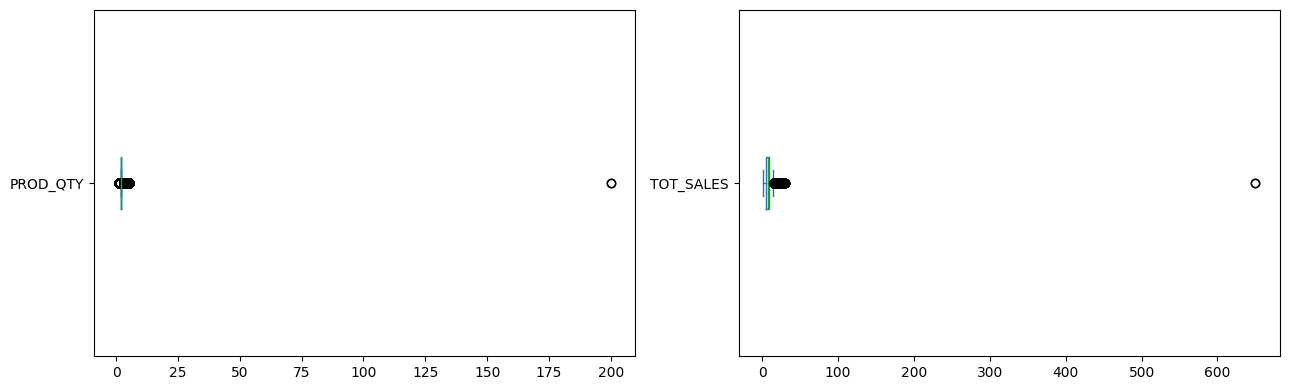

In [17]:
# Check box plot of numeric data

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

df_trans["PROD_QTY"].plot(kind="box", vert=False, ax=ax[0])
df_trans["TOT_SALES"].plot(kind="box", vert=False, ax=ax[1])

fig.tight_layout()

In [18]:
pd.merge(df_trans, df_purc, how="inner", on="LYLTY_CARD_NBR")[df_trans["PROD_QTY"] >= 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,PROD_UPRICE,LIFESTAGE,PREMIUM_CUSTOMER
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380,3.25,OLDER FAMILIES,Premium
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380,3.25,OLDER FAMILIES,Premium


**Remarks**
+ Transactions with 200 purchased items are clearly outliers relative to other transactions
+ There are two transactions with irrelevant time gap in between dates where this particular customer purchased a large quantity of chips (all Doritos Corn Chip Supreme 380g)
+ This customer `226000` is classified as `Premium` with the lifestage of `OLDER FAMILIES`
+ The transactions all occurred in the same store - `226`
+ It's a possibility that they own a smaller grocery or retail store and they're reselling the chips bought in bulk (buying for commercial use)
+ **Since our goal is to understand our customer base in general, we can filter this out from our analysis**

In [19]:
# Modify dataframe filtering the significant outliers for possible use later on

df_trans = df_trans[df_trans["LYLTY_CARD_NBR"] != 226000]
df_trans.shape

(264834, 10)

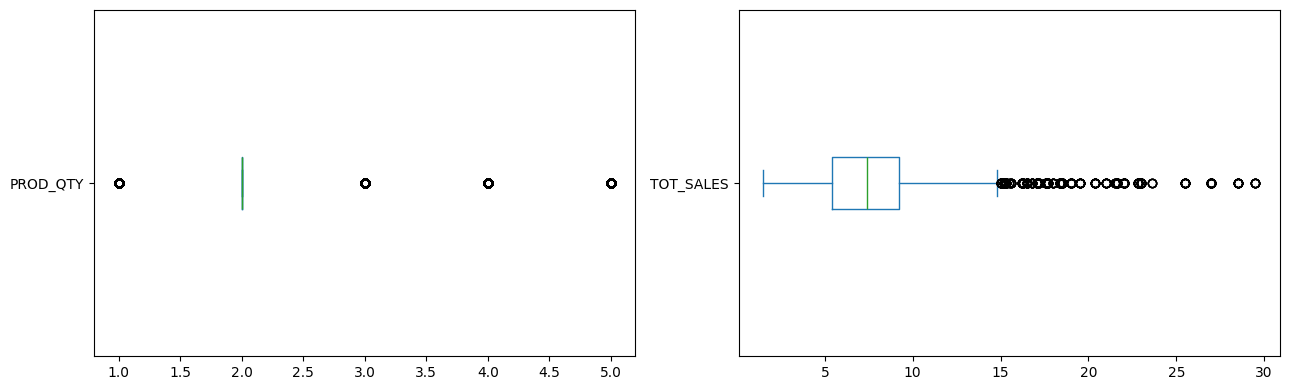

In [20]:
# Recheck box plot of numeric data

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))

df_trans["PROD_QTY"].plot(kind="box", vert=False, ax=ax[0])
df_trans["TOT_SALES"].plot(kind="box", vert=False, ax=ax[1])

fig.tight_layout()

There are still outliers relative to other records, but they are now relevant in understanding our customer segments.

Check if time period is exactly 1 year (365 days) and add any missing dates to dataframe.

In [21]:
df_trans["DATE"].nunique()

364

In [22]:
start_date, end_date = df_trans["DATE"].min(), df_trans["DATE"].max()
print(start_date)
print(end_date)

2018-07-01 00:00:00
2019-06-30 00:00:00


In [23]:
all_dates = pd.Series(pd.date_range(start=start_date, end=end_date), name="DATE")
all_dates.shape

(365,)

In [24]:
df_trans = pd.merge(all_dates, df_trans, how="left", on="DATE")
df_trans.shape

(264835, 10)

In [25]:
# Filter rows where any value in the row is null

df_trans[df_trans.isna().any(axis=1)]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,PROD_UPRICE
129324,2018-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


No record present during Christmas day means all stores were closed in that day.

Because the product names under the `PROD_NAME` column seems inconsistent, we can do some cleaning to fix the formatting of some words.

In [26]:
# prod_words = df_trans["PROD_NAME"].str.replace(r"[^a-zA-Z0-9\s]", "", regex=True).str.split(expand=True)
prod_words = df_trans["PROD_NAME"].str.split(expand=True)
for col in prod_words.columns:
    prod_words[col] = prod_words[col].str.lower()

prod_words

,0,1,2,3,4,5,6,7
0,smiths,crnkle,chip,orgnl,big,bag,None,None
1,pringles,sthrn,friedchicken,None,None,None,None,None
2,ccs,tasty,cheese,None,None,None,None,None
3,kettle,mozzarella,basil,pesto,None,None,None,None
4,thins,chips,light,tangy,None,None,None,None
...,...,...,...,...,...,...,...,...
264830,kettle,chilli,None,None,None,None,None,None
264831,doritos,corn,chip,southern,chicken,None,None,None
264832,woolworths,cheese,rings,None,None,None,None,None
264833,twisties,cheese,burger,None,None,None,None,None


Explore the relevant columns to check the products in the data.

In [27]:
prod_words[0].value_counts()

0
kettle        41288
smiths        28860
pringles      25102
doritos       24962
thins         14075
rrd           11894
infuzions     11057
ww            10320
cobs           9693
tostitos       9471
twisties       9454
old            9324
tyrrells       6442
grain          6272
natural        6050
red            5885
cheezels       4603
ccs            4551
woolworths     4437
dorito         3183
infzns         3144
smith          2963
cheetos        2927
snbts          1576
burger         1564
grnwves        1468
sunbites       1432
ncc            1419
french         1418
Name: count, dtype: int64

The first word refers to the brand names. We can clean the names later.

In [28]:
prod_words[1].value_counts()

1
crinkle       23960
corn          19057
cheese        15455
chips         10846
original      10812
popd           9693
tortilla       9580
sensations     9429
el             9324
sweet          7893
chip           7567
crisps         6442
sourcream      6296
chicken        6274
waves          6272
rock           5885
honey          4661
chilli         4544
mozzarella     3304
swt            3257
splash         3252
thai           3242
crnkle         3233
potato         3229
barbeque       3210
bbq            3174
sea            3173
smoked         3145
crn            3144
mexicana       3115
mystery        3114
slt            3095
sthrn          3083
lightly        3074
chipco         3010
thinly         2980
salsa          2921
sour           2902
whlgrn         1576
rings          1564
tasty          1539
sr             1526
supreme        1509
mango          1507
nacho          1498
mild           1491
chs            1479
salt           1474
lime           1473
d              146

In [29]:
prod_words[2].value_counts()

2
cut            19140
chips          15924
chip            9609
salt            9380
paso            9324
               ...  
chimuchurri     1455
box             1454
medium          1449
originl         1441
potato          1418
Name: count, Length: 65, dtype: int64

In [30]:
prod_words[3].value_counts()

3
salt       10898
chips      10315
salsa       9324
lime        6379
and         6373
           ...  
cutsalt     1440
french      1438
chikn       1434
frch        1432
garden      1419
Name: count, Length: 62, dtype: int64

There are Salsa products in the data, which we're not interested with. We can filter them out to make sure we're working with potato chip products.

In [31]:
# Check all salsa products included in the data

df_trans[df_trans["PROD_NAME"].str.lower().str.contains("salsa", na=False)]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,PROD_UPRICE
6,2018-07-01,78.0,78009.0,75510.0,35.0,Woolworths Mild Salsa,2.0,3.0,300.0,1.5
11,2018-07-01,128.0,128169.0,131648.0,59.0,Old El Paso Salsa Dip Tomato Med,2.0,10.2,300.0,5.1
29,2018-07-01,59.0,59053.0,54823.0,59.0,Old El Paso Salsa Dip Tomato Med,2.0,10.2,300.0,5.1
46,2018-07-01,213.0,213065.0,212270.0,57.0,Old El Paso Salsa Dip Tomato Mild,2.0,10.2,300.0,5.1
60,2018-07-01,37.0,37132.0,33645.0,59.0,Old El Paso Salsa Dip Tomato Med,2.0,10.2,300.0,5.1
...,...,...,...,...,...,...,...,...,...,...
264782,2019-06-30,166.0,166279.0,168383.0,59.0,Old El Paso Salsa Dip Tomato Med,2.0,10.2,300.0,5.1
264799,2019-06-30,221.0,221158.0,220686.0,57.0,Old El Paso Salsa Dip Tomato Mild,2.0,10.2,300.0,5.1
264801,2019-06-30,223.0,223235.0,224358.0,57.0,Old El Paso Salsa Dip Tomato Mild,2.0,10.2,300.0,5.1
264814,2019-06-30,7.0,7010.0,6350.0,59.0,Old El Paso Salsa Dip Tomato Med,2.0,10.2,300.0,5.1


In [32]:
prod_words[0].unique()

array(['smiths', 'pringles', 'ccs', 'kettle', 'thins', 'infuzions',
       'woolworths', 'grnwves', 'rrd', 'twisties', 'red', 'old',
       'cheezels', 'tostitos', 'ww', 'grain', 'doritos', 'cobs',
       'natural', 'burger', 'dorito', 'cheetos', 'smith', 'french', 'ncc',
       'infzns', 'sunbites', 'tyrrells', 'snbts', nan], dtype=object)

In [33]:
# Clean brand names

corrected_brand_names = {
    "red": "rrd",
    "snbts": "sunbites",
    "infzns": "infuzions",
    "ww": "woolworths",
    "smith": "smiths",
    "ncc": "natural",
    "dorito": "doritos",
    "grain": "grnwves"
}

# Use .map() to replace values and .fillna() to preserve unmatched values

prod_words[0] = prod_words[0].map(corrected_brand_names, na_action="ignore").fillna(prod_words[0])

In [34]:
prod_words[0].value_counts()

0
kettle        41288
smiths        31823
doritos       28145
pringles      25102
rrd           17779
woolworths    14757
infuzions     14201
thins         14075
cobs           9693
tostitos       9471
twisties       9454
old            9324
grnwves        7740
natural        7469
tyrrells       6442
cheezels       4603
ccs            4551
sunbites       3008
cheetos        2927
burger         1564
french         1418
Name: count, dtype: int64

In [35]:
prod_words.iloc[129324]

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
Name: 129324, dtype: object

In [36]:
# Recombine the clean splitted words of product names

prod_name_cleaned = prod_words.fillna("").agg(" ".join, axis=1).str.strip().str.title()
prod_name_cleaned

0           Smiths Crnkle Chip Orgnl Big Bag
1                Pringles Sthrn Friedchicken
2                           Ccs Tasty Cheese
3              Kettle Mozzarella Basil Pesto
4                    Thins Chips Light Tangy
                         ...                
264830                         Kettle Chilli
264831    Doritos Corn Chip Southern Chicken
264832               Woolworths Cheese Rings
264833                Twisties Cheese Burger
264834         Natural Chipco Hony Soy Chckn
Length: 264835, dtype: object

In [37]:
# Replace the product name column with the cleaned product name

df_trans["PROD_NAME"] = prod_name_cleaned
df_trans["PROD_BRAND"] = prod_words[0].str.upper()

In [38]:
df_trans

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,PROD_UPRICE,PROD_BRAND
0,2018-07-01,47.0,47142.0,42540.0,14.0,Smiths Crnkle Chip Orgnl Big Bag,2.0,11.8,380.0,5.9,SMITHS
1,2018-07-01,55.0,55073.0,48884.0,99.0,Pringles Sthrn Friedchicken,2.0,7.4,134.0,3.7,PRINGLES
2,2018-07-01,55.0,55073.0,48884.0,91.0,Ccs Tasty Cheese,2.0,4.2,175.0,2.1,CCS
3,2018-07-01,58.0,58351.0,54374.0,102.0,Kettle Mozzarella Basil Pesto,2.0,10.8,175.0,5.4,KETTLE
4,2018-07-01,68.0,68193.0,65598.0,44.0,Thins Chips Light Tangy,2.0,6.6,175.0,3.3,THINS
...,...,...,...,...,...,...,...,...,...,...,...
264830,2019-06-30,242.0,242159.0,246222.0,36.0,Kettle Chilli,2.0,10.8,175.0,5.4,KETTLE
264831,2019-06-30,244.0,244213.0,247339.0,93.0,Doritos Corn Chip Southern Chicken,2.0,7.8,150.0,3.9,DORITOS
264832,2019-06-30,256.0,256018.0,255130.0,105.0,Woolworths Cheese Rings,2.0,3.6,190.0,1.8,WOOLWORTHS
264833,2019-06-30,257.0,257079.0,256218.0,71.0,Twisties Cheese Burger,2.0,8.6,250.0,4.3,TWISTIES


In [39]:
# We can now conveniently remove the salsa products that are not relevant to our analysis

df_trans = df_trans[~df_trans["PROD_NAME"].str.lower().str.contains("salsa", na=False)]
df_trans

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,PROD_UPRICE,PROD_BRAND
0,2018-07-01,47.0,47142.0,42540.0,14.0,Smiths Crnkle Chip Orgnl Big Bag,2.0,11.8,380.0,5.9,SMITHS
1,2018-07-01,55.0,55073.0,48884.0,99.0,Pringles Sthrn Friedchicken,2.0,7.4,134.0,3.7,PRINGLES
2,2018-07-01,55.0,55073.0,48884.0,91.0,Ccs Tasty Cheese,2.0,4.2,175.0,2.1,CCS
3,2018-07-01,58.0,58351.0,54374.0,102.0,Kettle Mozzarella Basil Pesto,2.0,10.8,175.0,5.4,KETTLE
4,2018-07-01,68.0,68193.0,65598.0,44.0,Thins Chips Light Tangy,2.0,6.6,175.0,3.3,THINS
...,...,...,...,...,...,...,...,...,...,...,...
264830,2019-06-30,242.0,242159.0,246222.0,36.0,Kettle Chilli,2.0,10.8,175.0,5.4,KETTLE
264831,2019-06-30,244.0,244213.0,247339.0,93.0,Doritos Corn Chip Southern Chicken,2.0,7.8,150.0,3.9,DORITOS
264832,2019-06-30,256.0,256018.0,255130.0,105.0,Woolworths Cheese Rings,2.0,3.6,190.0,1.8,WOOLWORTHS
264833,2019-06-30,257.0,257079.0,256218.0,71.0,Twisties Cheese Burger,2.0,8.6,250.0,4.3,TWISTIES


In [40]:
df_trans.isna().sum()

DATE              0
STORE_NBR         1
LYLTY_CARD_NBR    1
TXN_ID            1
PROD_NBR          1
PROD_NAME         0
PROD_QTY          1
TOT_SALES         1
PROD_WT           1
PROD_UPRICE       1
PROD_BRAND        1
dtype: int64

In [41]:
df_main = pd.merge(df_trans, df_purc, how="left", on="LYLTY_CARD_NBR").reset_index(drop=True)
df_main

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,PROD_UPRICE,PROD_BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-07-01,47.0,47142.0,42540.0,14.0,Smiths Crnkle Chip Orgnl Big Bag,2.0,11.8,380.0,5.9,SMITHS,MIDAGE SINGLES/COUPLES,Budget
1,2018-07-01,55.0,55073.0,48884.0,99.0,Pringles Sthrn Friedchicken,2.0,7.4,134.0,3.7,PRINGLES,MIDAGE SINGLES/COUPLES,Budget
2,2018-07-01,55.0,55073.0,48884.0,91.0,Ccs Tasty Cheese,2.0,4.2,175.0,2.1,CCS,MIDAGE SINGLES/COUPLES,Budget
3,2018-07-01,58.0,58351.0,54374.0,102.0,Kettle Mozzarella Basil Pesto,2.0,10.8,175.0,5.4,KETTLE,MIDAGE SINGLES/COUPLES,Budget
4,2018-07-01,68.0,68193.0,65598.0,44.0,Thins Chips Light Tangy,2.0,6.6,175.0,3.3,THINS,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246736,2019-06-30,242.0,242159.0,246222.0,36.0,Kettle Chilli,2.0,10.8,175.0,5.4,KETTLE,YOUNG SINGLES/COUPLES,Premium
246737,2019-06-30,244.0,244213.0,247339.0,93.0,Doritos Corn Chip Southern Chicken,2.0,7.8,150.0,3.9,DORITOS,YOUNG SINGLES/COUPLES,Premium
246738,2019-06-30,256.0,256018.0,255130.0,105.0,Woolworths Cheese Rings,2.0,3.6,190.0,1.8,WOOLWORTHS,YOUNG SINGLES/COUPLES,Premium
246739,2019-06-30,257.0,257079.0,256218.0,71.0,Twisties Cheese Burger,2.0,8.6,250.0,4.3,TWISTIES,YOUNG SINGLES/COUPLES,Premium


In [42]:
df_main[df_main.isna().any(axis=1)]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PROD_WT,PROD_UPRICE,PROD_BRAND,LIFESTAGE,PREMIUM_CUSTOMER
120465,2018-12-25,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246741 entries, 0 to 246740
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              246741 non-null  datetime64[ns]
 1   STORE_NBR         246740 non-null  float64       
 2   LYLTY_CARD_NBR    246740 non-null  float64       
 3   TXN_ID            246740 non-null  float64       
 4   PROD_NBR          246740 non-null  float64       
 5   PROD_NAME         246741 non-null  object        
 6   PROD_QTY          246740 non-null  float64       
 7   TOT_SALES         246740 non-null  float64       
 8   PROD_WT           246740 non-null  float64       
 9   PROD_UPRICE       246740 non-null  float64       
 10  PROD_BRAND        246740 non-null  object        
 11  LIFESTAGE         246740 non-null  object        
 12  PREMIUM_CUSTOMER  246740 non-null  object        
dtypes: datetime64[ns](1), float64(8), object(4)
memory usage: 2

In [44]:
# Reformat data types that we're unintentionally converted into floats from previous merges

df_main = df_main.astype({
    "STORE_NBR": "Int64",
    "LYLTY_CARD_NBR": "Int64",
    "TXN_ID": "Int64",
    "PROD_NBR": "Int64",
    "PROD_QTY": "Int64",
    "PROD_WT": "Int64"
})

In [45]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246741 entries, 0 to 246740
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              246741 non-null  datetime64[ns]
 1   STORE_NBR         246740 non-null  Int64         
 2   LYLTY_CARD_NBR    246740 non-null  Int64         
 3   TXN_ID            246740 non-null  Int64         
 4   PROD_NBR          246740 non-null  Int64         
 5   PROD_NAME         246741 non-null  object        
 6   PROD_QTY          246740 non-null  Int64         
 7   TOT_SALES         246740 non-null  float64       
 8   PROD_WT           246740 non-null  Int64         
 9   PROD_UPRICE       246740 non-null  float64       
 10  PROD_BRAND        246740 non-null  object        
 11  LIFESTAGE         246740 non-null  object        
 12  PREMIUM_CUSTOMER  246740 non-null  object        
dtypes: Int64(6), datetime64[ns](1), float64(2), object(4)
memor

In [46]:
# Export merged data for later use

df_main.to_csv(DATA_DIR / "QVI_cleaned.csv", index=False)

# Exploration proper

## Customer segments

In [47]:
# To understand how large is our current customers, consider only the customers with purchased made within the time period

customer_info = ["LYLTY_CARD_NBR", "LIFESTAGE", "PREMIUM_CUSTOMER"]

customers_with_record = df_main.loc[:, customer_info].drop_duplicates(subset=customer_info[0]).dropna().reset_index(drop=True)
customers_with_record

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,47142,MIDAGE SINGLES/COUPLES,Budget
1,55073,MIDAGE SINGLES/COUPLES,Budget
2,58351,MIDAGE SINGLES/COUPLES,Budget
3,68193,MIDAGE SINGLES/COUPLES,Budget
4,69207,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...
71282,6358,YOUNG SINGLES/COUPLES,Premium
71283,90228,YOUNG SINGLES/COUPLES,Premium
71284,169080,YOUNG SINGLES/COUPLES,Premium
71285,244213,YOUNG SINGLES/COUPLES,Premium


In [48]:
df_main.nunique()

DATE                   365
STORE_NBR              271
LYLTY_CARD_NBR       71287
TXN_ID              245255
PROD_NBR               105
PROD_NAME              106
PROD_QTY                 5
TOT_SALES              104
PROD_WT                 20
PROD_UPRICE             47
PROD_BRAND              20
LIFESTAGE                7
PREMIUM_CUSTOMER         3
dtype: int64

In [49]:
customers_with_record.nunique()

LYLTY_CARD_NBR      71287
LIFESTAGE               7
PREMIUM_CUSTOMER        3
dtype: int64

In [50]:
pd.concat(
    [customers_with_record["PREMIUM_CUSTOMER"].value_counts(), (customers_with_record["PREMIUM_CUSTOMER"].value_counts(normalize=True) * 100).round(2)],
    axis=1,
    keys=["COUNT", "PERCENTAGE"]  
)

,COUNT,PERCENTAGE
PREMIUM_CUSTOMER,,
Mainstream,28734,40.31
Budget,24006,33.68
Premium,18547,26.02


In [51]:
pd.concat(
    [customers_with_record["LIFESTAGE"].value_counts(), (customers_with_record["LIFESTAGE"].value_counts(normalize=True) * 100).round(2)],
    axis=1,
    keys=["COUNT", "PERCENTAGE"]  
)

,COUNT,PERCENTAGE
LIFESTAGE,,
RETIREES,14555,20.42
OLDER SINGLES/COUPLES,14389,20.18
YOUNG SINGLES/COUPLES,14044,19.70
OLDER FAMILIES,9630,13.51
YOUNG FAMILIES,9036,12.68
MIDAGE SINGLES/COUPLES,7141,10.02
NEW FAMILIES,2492,3.50


In [52]:
# mainstream_customers = customers_with_record[customers_with_record["PREMIUM_CUSTOMER"] == "Mainstream"]["LIFESTAGE"].value_counts(ascending=False)
# budget_customers = customers_with_record[customers_with_record["PREMIUM_CUSTOMER"] == "Budget"]["LIFESTAGE"].value_counts(ascending=False)
# premium_customers = customers_with_record[customers_with_record["PREMIUM_CUSTOMER"] == "Premium"]["LIFESTAGE"].value_counts(ascending=False)

mainstream_customers = customers_with_record[customers_with_record["PREMIUM_CUSTOMER"] == "Mainstream"]["LIFESTAGE"].value_counts()
budget_customers = customers_with_record[customers_with_record["PREMIUM_CUSTOMER"] == "Budget"]["LIFESTAGE"].value_counts()
premium_customers = customers_with_record[customers_with_record["PREMIUM_CUSTOMER"] == "Premium"]["LIFESTAGE"].value_counts()

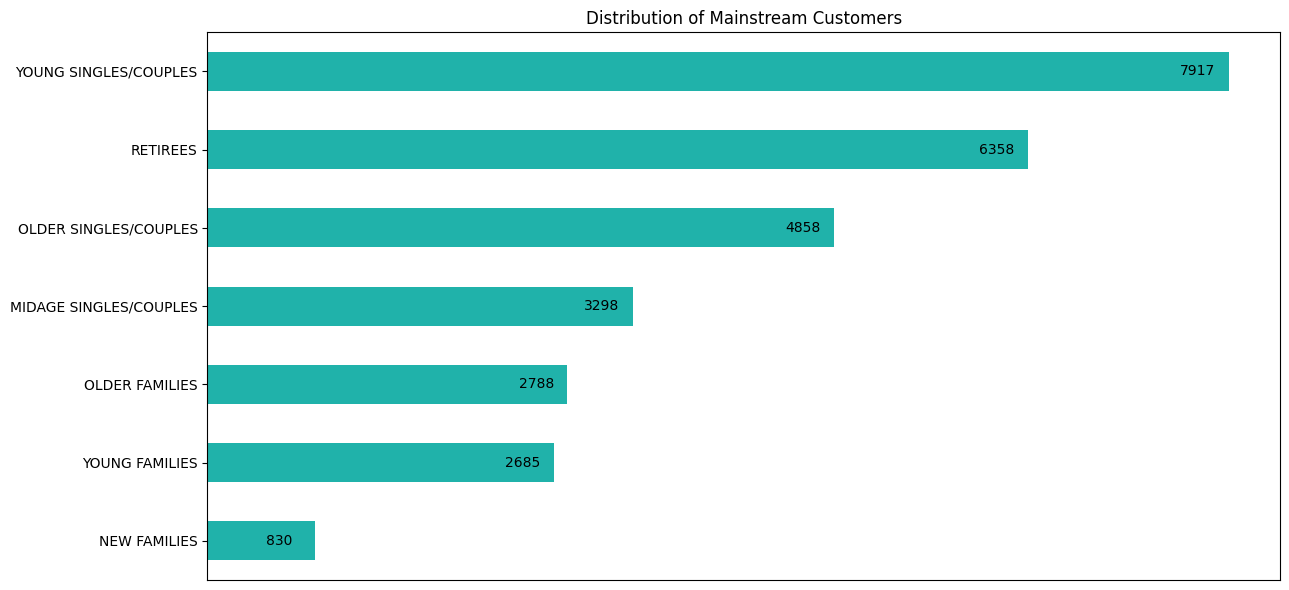

In [53]:
fig, ax = plt.subplots(figsize=(13, 6))

mainstream_customers.sort_values().plot(
    kind="barh",
    color="lightseagreen",
    xlabel="",
    ylabel="",
    title="Distribution of Mainstream Customers",
    ax=ax
)
ax.bar_label(ax.containers[0], padding=-35)
ax.tick_params(
    axis="x",
    which="both",
    bottom=False,
    labelbottom=False
)

fig.tight_layout()

In [54]:
(customers_with_record[customers_with_record["PREMIUM_CUSTOMER"] == "Mainstream"]["LIFESTAGE"].value_counts(normalize=True) * 100).round(2)

LIFESTAGE
YOUNG SINGLES/COUPLES     27.55
RETIREES                  22.13
OLDER SINGLES/COUPLES     16.91
MIDAGE SINGLES/COUPLES    11.48
OLDER FAMILIES             9.70
YOUNG FAMILIES             9.34
NEW FAMILIES               2.89
Name: proportion, dtype: float64

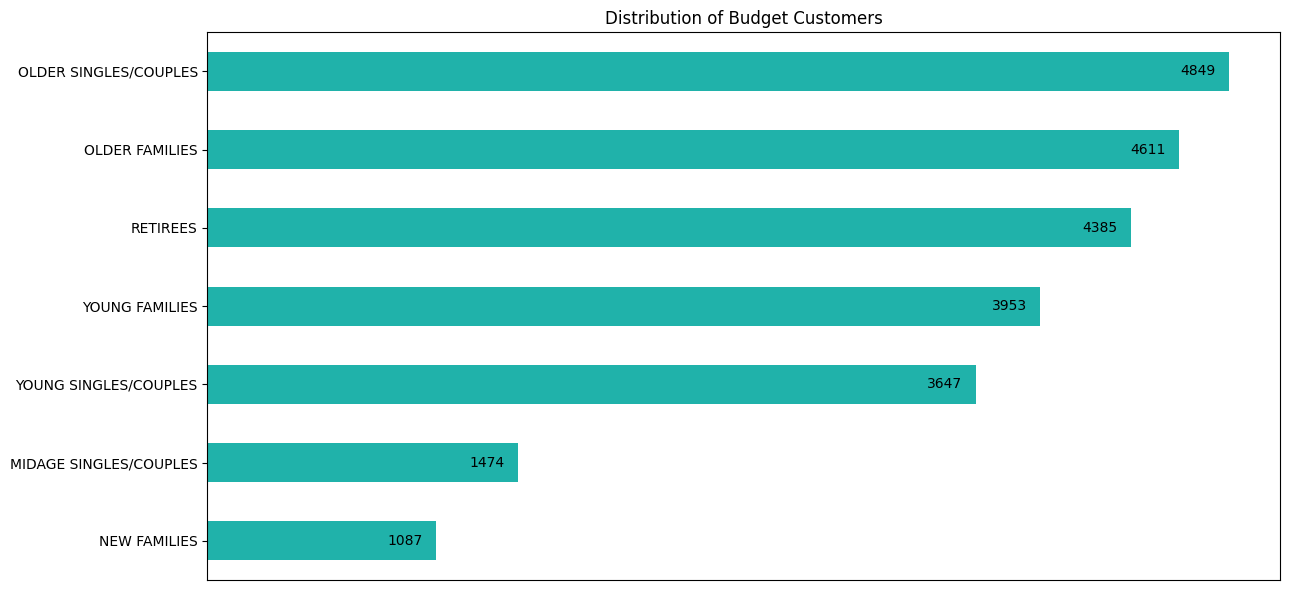

In [55]:
fig, ax = plt.subplots(figsize=(13, 6))

budget_customers.sort_values().plot(
    kind="barh",
    color="lightseagreen",
    xlabel="",
    ylabel="",
    title="Distribution of Budget Customers",
    ax=ax
)
ax.bar_label(ax.containers[0], padding=-35)
ax.tick_params(
    axis="x",
    which="both",
    bottom=False,
    labelbottom=False
)


fig.tight_layout()

In [56]:
(customers_with_record[customers_with_record["PREMIUM_CUSTOMER"] == "Budget"]["LIFESTAGE"].value_counts(normalize=True) * 100).round(2)

LIFESTAGE
OLDER SINGLES/COUPLES     20.20
OLDER FAMILIES            19.21
RETIREES                  18.27
YOUNG FAMILIES            16.47
YOUNG SINGLES/COUPLES     15.19
MIDAGE SINGLES/COUPLES     6.14
NEW FAMILIES               4.53
Name: proportion, dtype: float64

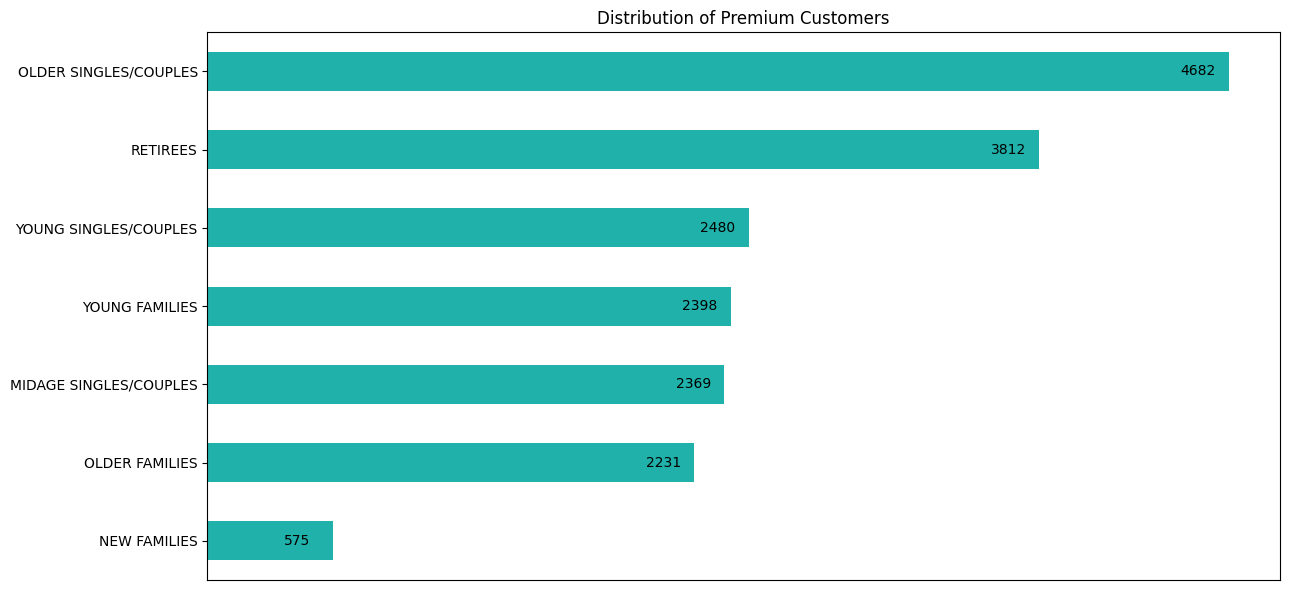

In [57]:
fig, ax = plt.subplots(figsize=(13, 6))

premium_customers.sort_values().plot(
    kind="barh",
    color="lightseagreen",
    xlabel="",
    ylabel="",
    title="Distribution of Premium Customers",
    ax=ax
)
ax.bar_label(ax.containers[0], padding=-35)
ax.tick_params(
    axis="x",
    which="both",
    bottom=False,
    labelbottom=False
)

fig.tight_layout()

In [58]:
(customers_with_record[customers_with_record["PREMIUM_CUSTOMER"] == "Premium"]["LIFESTAGE"].value_counts(normalize=True) * 100).round(2)

LIFESTAGE
OLDER SINGLES/COUPLES     25.24
RETIREES                  20.55
YOUNG SINGLES/COUPLES     13.37
YOUNG FAMILIES            12.93
MIDAGE SINGLES/COUPLES    12.77
OLDER FAMILIES            12.03
NEW FAMILIES               3.10
Name: proportion, dtype: float64

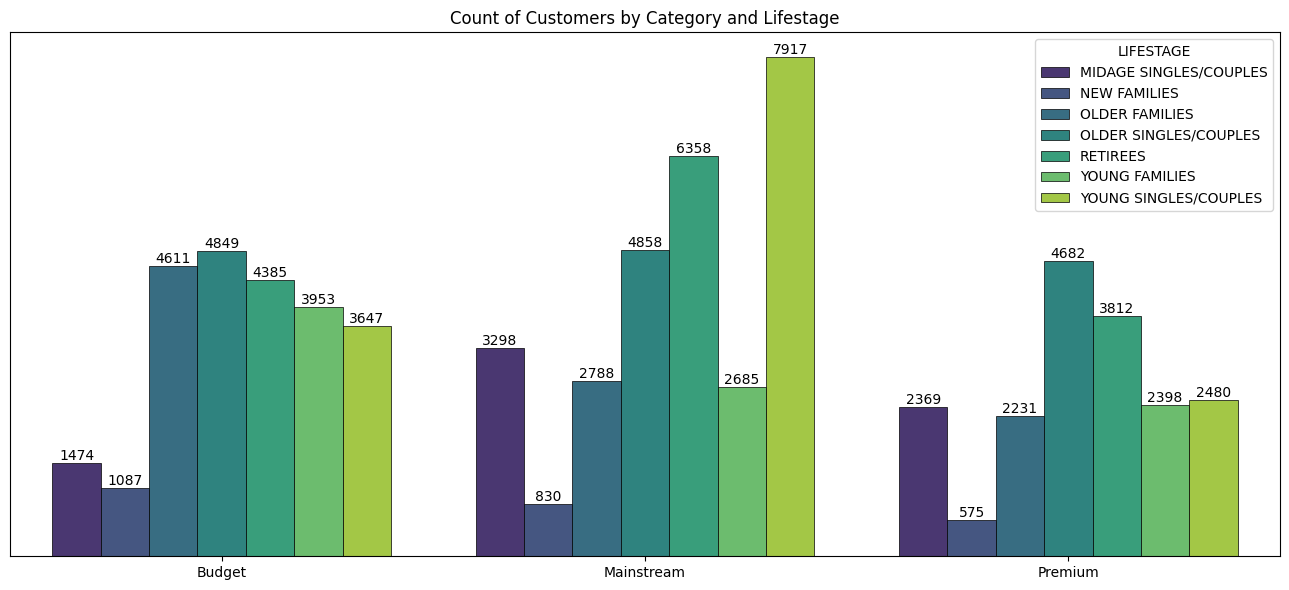

In [59]:
fig, ax = plt.subplots(figsize=(13, 6))

sns.countplot(
    data=customers_with_record, 
    x="PREMIUM_CUSTOMER", 
    hue="LIFESTAGE", 
    palette="viridis", 
    edgecolor="black", 
    lw=0.5
)
for container in ax.containers:
    ax.bar_label(container)
ax.tick_params(
    axis="y",
    which="both",
    left=False,
    labelleft=False
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Count of Customers by Category and Lifestage")


fig.tight_layout()
fig.savefig("./static/customers_count.jpg", bbox_inches="tight")

## Customer transactions

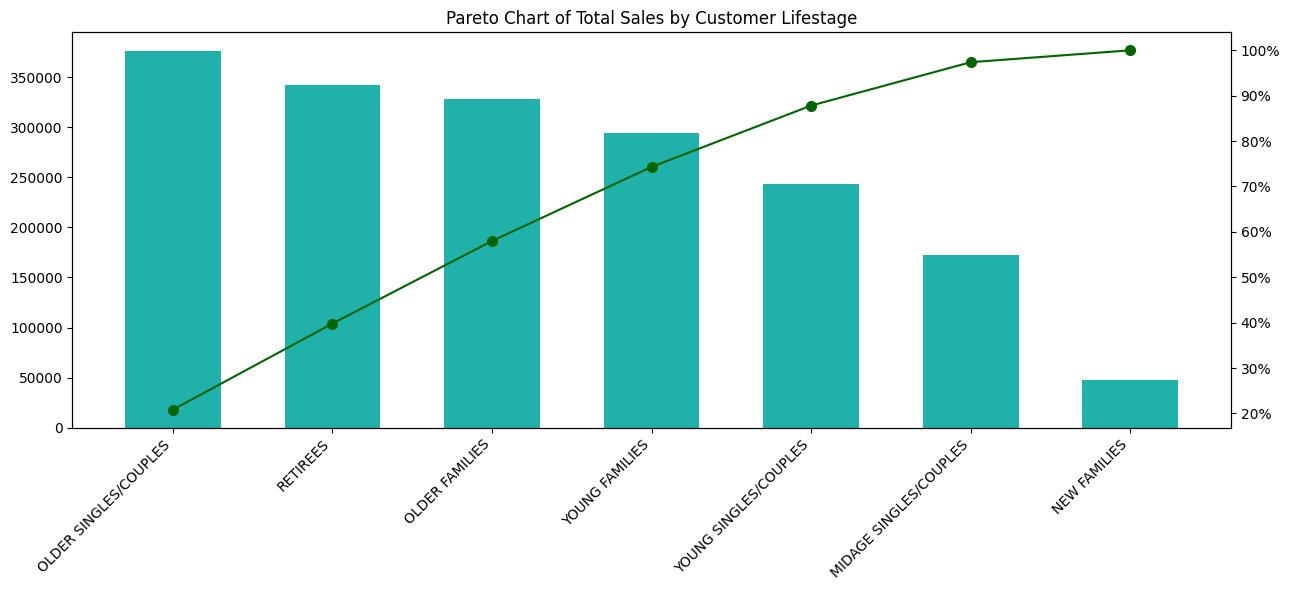

In [60]:
# Checking Pareto Chart by Total Sales

sales_pareto = df_main.groupby("LIFESTAGE")["TOT_SALES"].sum().sort_values(ascending=False).to_frame()
sales_pareto["PERCENT_SALE"] = sales_pareto["TOT_SALES"] / sales_pareto["TOT_SALES"].sum() * 100
sales_pareto["CUMSUM"] = sales_pareto["TOT_SALES"].cumsum() / sales_pareto["TOT_SALES"].sum() * 100


fig, ax = plt.subplots(figsize=(13, 6))

ax.bar(sales_pareto.index, sales_pareto["TOT_SALES"], color="lightseagreen", width=0.6)
ax2 = ax.twinx()
ax2.plot(sales_pareto.index, sales_pareto["CUMSUM"], color="darkgreen", marker="o", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y")
ax2.tick_params(axis="y")

ax.set_xticks(range(len(sales_pareto)))
ax.set_xticklabels(sales_pareto.index, rotation=45, ha='right')
ax.set_title("Pareto Chart of Total Sales by Customer Lifestage")


fig.tight_layout()
fig.savefig("./static/pareto_sales_by_lifestage.jpg", bbox_inches="tight")

In [61]:
sales_pareto.round(3)

,TOT_SALES,PERCENT_SALE,CUMSUM
LIFESTAGE,,,
OLDER SINGLES/COUPLES,376019.65,20.830,20.830
RETIREES,342381.90,18.967,39.797
OLDER FAMILIES,328519.90,18.199,57.995
YOUNG FAMILIES,294627.90,16.321,74.317
YOUNG SINGLES/COUPLES,243756.60,13.503,87.820
MIDAGE SINGLES/COUPLES,172523.80,9.557,97.377
NEW FAMILIES,47347.95,2.623,100.000


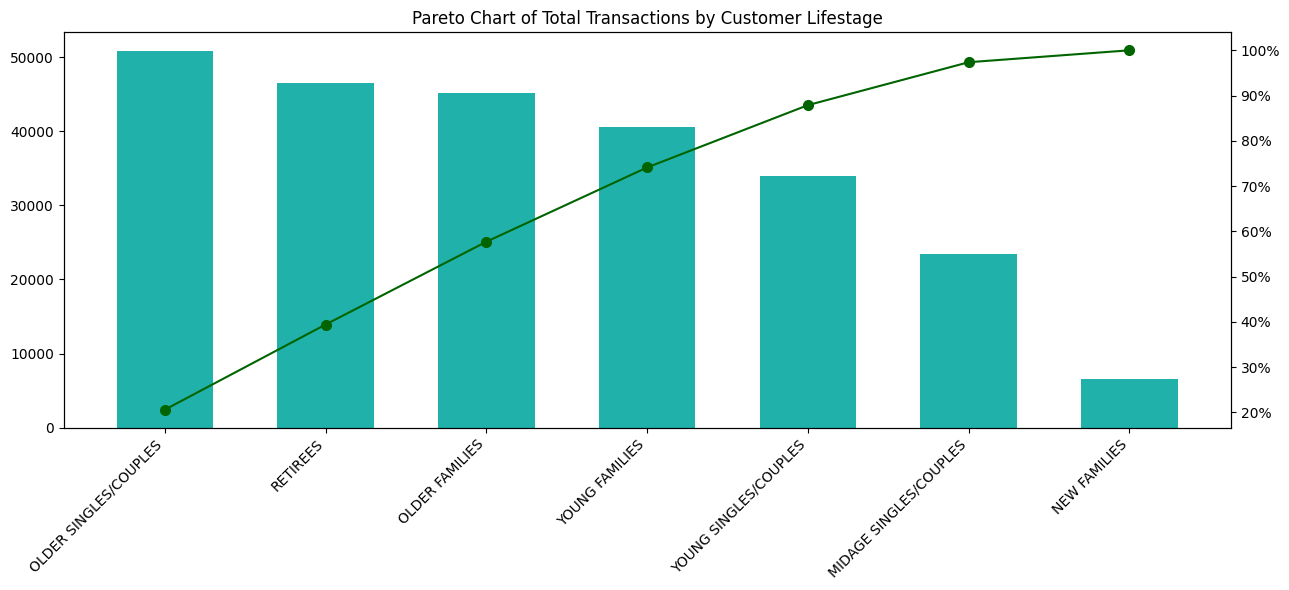

In [62]:
# Checking Pareto Chart by Total Transactions

transaction_pareto = df_main["LIFESTAGE"].value_counts().sort_values(ascending=False).to_frame()
transaction_pareto["cumsum"] = transaction_pareto.cumsum() / transaction_pareto.sum() * 100


fig, ax = plt.subplots(figsize=(13, 6))

ax.bar(transaction_pareto.index, transaction_pareto["count"], color="lightseagreen", width=0.6)
ax2 = ax.twinx()
ax2.plot(transaction_pareto.index, transaction_pareto["cumsum"], color="darkgreen", marker="o", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y")
ax2.tick_params(axis="y")

ax.set_xticks(range(len(transaction_pareto)))
ax.set_xticklabels(transaction_pareto.index, rotation=45, ha='right')
ax.set_title("Pareto Chart of Total Transactions by Customer Lifestage")


fig.tight_layout()
fig.savefig("./static/pareto_trans_by_lifestage.jpg", bbox_inches="tight")

In [63]:
transaction_pareto.round(3)

,count,cumsum
LIFESTAGE,,
OLDER SINGLES/COUPLES,50793,20.586
RETIREES,46431,39.403
OLDER FAMILIES,45158,57.705
YOUNG FAMILIES,40494,74.117
YOUNG SINGLES/COUPLES,33969,87.884
MIDAGE SINGLES/COUPLES,23398,97.367
NEW FAMILIES,6497,100.000


**Remarks**
+ Judging the total sales from mid-2018 to mid-2019, there are **5 out of 7** lifestages that contributes to atleast 80% of it.
+ On the other hand, looking at total transactions shows that the results in total sales is consistent (i.e. also 5 of 7 lifestages contributing to 80%)
+ This implies the business sales rely on many customer segments.
+ We can check the total sales per transaction in every lifestage to get a better idea.

In [64]:
# trans_lifestage = pd.pivot_table(data=df_main, values="TOT_SALES", index="LIFESTAGE", aggfunc=["sum", "count"])
# trans_lifestage.columns = [f"{col[0]}_sales".upper() for col in trans_lifestage.columns]
# trans_lifestage["SALES_PER_TRANS"] = (trans_lifestage["SUM_SALES"] / trans_lifestage["COUNT_SALES"]).round(2)
# trans_lifestage.sort_values(by="SALES_PER_TRANS", ascending=False)

trans_lifestage = pd.pivot_table(data=df_main, values="TOT_SALES", index="LIFESTAGE", aggfunc=["sum", "count", "mean"])
trans_lifestage.columns = [f"{col[0]}_sales".upper() for col in trans_lifestage.columns]
trans_lifestage["PERCENT_SALES"] = trans_lifestage["SUM_SALES"] / trans_lifestage["SUM_SALES"].sum() * 100
trans_lifestage.sort_values(by="MEAN_SALES", ascending=False).round(3)

,SUM_SALES,COUNT_SALES,MEAN_SALES,PERCENT_SALES
LIFESTAGE,,,,
OLDER SINGLES/COUPLES,376019.65,50793,7.403,20.830
RETIREES,342381.90,46431,7.374,18.967
MIDAGE SINGLES/COUPLES,172523.80,23398,7.373,9.557
NEW FAMILIES,47347.95,6497,7.288,2.623
YOUNG FAMILIES,294627.90,40494,7.276,16.321
OLDER FAMILIES,328519.90,45158,7.275,18.199
YOUNG SINGLES/COUPLES,243756.60,33969,7.176,13.503


Comparing `RETIREES` and `MIDAGE SINGLES/COUPLES`, their mean sales generally being very similar is interesting. We can test its statistical significance.

In [65]:
trans_customer_cat = pd.pivot_table(data=df_main, values="TOT_SALES", index="PREMIUM_CUSTOMER", aggfunc=["sum", "count", "mean", "median"])
trans_customer_cat.columns = [f"{col[0]}_sales".upper() for col in trans_customer_cat.columns]
trans_customer_cat["PERCENT_SALES"] = trans_customer_cat["SUM_SALES"] / trans_customer_cat["SUM_SALES"].sum() * 100

trans_customer_cat.sort_values(by="SUM_SALES", ascending=False).round(3)

,SUM_SALES,COUNT_SALES,MEAN_SALES,MEDIAN_SALES,PERCENT_SALES
PREMIUM_CUSTOMER,,,,,
Mainstream,700865.40,95043,7.374,7.4,38.825
Budget,631406.85,86762,7.277,7.4,34.978
Premium,472905.45,64935,7.283,7.4,26.197


In [66]:
# Check statistical significance between mean sales of Retirees and Midage Singles/Couples
# Assume unequal variance, hence consider Welch t test

group_1 = df_main[df_main["LIFESTAGE"] == "RETIREES"]["TOT_SALES"]
group_2 = df_main[df_main["LIFESTAGE"] == "MIDAGE SINGLES/COUPLES"]["TOT_SALES"]

print(group_1.shape, group_2.shape)
print(group_1.mean(), group_2.mean())

ttest_ind(group_1, group_2, equal_var=False, alternative="two-sided")

(46431,) (23398,)
7.37399366802352 7.373442174544833


TtestResult(statistic=np.float64(0.027719451275812605), pvalue=np.float64(0.9778860279651558), df=np.float64(46805.942468034445))

p-value is too large, hence there is strong evidence that the Retirees and Midage Singles/Couples mean sales are not significantly different.

**Remarks**
+ `OLDER SINGLES/COUPLES` and `RETIREES` are consistent to be the top drivers for sales based on pareto charts and mean sales and it could because it's a consequence of having large total transactions. We can further drill this down by customer category to get a better idea.
+ Interestingly, `MIDAGE SINGLE/COUPLES` provide sale amount per transaction comparable to the top ones despite being the bottom two in terms of total sales made and total transactions. This could mean they tend to buy more chip packs in a single transaction. If sale promos are to be made, they could be one of the customer segments to look for in terms of lifestage.
+ Generally, sale amount per transactions ranges between 7.2 and 7.4 USD.

In [67]:
trans_lifestage_cat = pd.pivot_table(data=df_main, values="TOT_SALES", index=["LIFESTAGE", "PREMIUM_CUSTOMER"], aggfunc=["sum", "count", "mean"])
trans_lifestage_cat.columns = [f"{col[0]}_sales".upper() for col in trans_lifestage_cat.columns]
trans_lifestage_cat["PERCENT_SALES"] = trans_lifestage_cat["SUM_SALES"] / trans_lifestage_cat["SUM_SALES"].sum() * 100
trans_lifestage_cat.round(2)

SUM_SALES  COUNT_SALES  MEAN_SALES  \
LIFESTAGE              PREMIUM_CUSTOMER                                       
MIDAGE SINGLES/COUPLES Budget             33345.70         4691        7.11   
                       Mainstream         84734.25        11095        7.64   
                       Premium            54443.85         7612        7.15   
NEW FAMILIES           Budget             20607.45         2824        7.30   
                       Mainstream         15979.70         2185        7.31   
                       Premium            10760.80         1488        7.23   
OLDER FAMILIES         Budget            156863.75        21514        7.29   
                       Mainstream         96413.55        13241        7.28   
                       Premium            75242.60        10403        7.23   
OLDER SINGLES/COUPLES  Budget            127833.60        17172        7.44   
                       Mainstream        124648.50        17061        7.31   
                       Premium           123537.55        16560        7.46   
RETIREES               Budget            105916.30        14225        7.45   
                       Mainstream        145168.95        19970        7.27   
                       Premium            91296.65        12236        7.46   
YOUNG FAMILIES         Budget            129717.95        17763        7.30   
                       Mainstream         86338.25        11947        7.23   
                       Premium            78571.70        10784        7.29   
YOUNG SINGLES/COUPLES  Budget             57122.10         8573        6.66   
                       Mainstream        147582.20        19544        7.55   
                       Premium            39052.30         5852        6.67   

                                         PERCENT_SALES  
LIFESTAGE              PREMIUM_CUSTOMER                 
MIDAGE SINGLES/COUPLES Budget                     1.85  
                       Mainstream                 4.69  
                       Premium                    3.02  
NEW FAMILIES           Budget                     1.14  
                       Mainstream                 0.89  
                       Premium                    0.60  
OLDER FAMILIES         Budget                     8.69  
                       Mainstream                 5.34  
                       Premium                    4.17  
OLDER SINGLES/COUPLES  Budget                     7.08  
                       Mainstream                 6.91  
                       Premium                    6.84  
RETIREES               Budget                     5.87  
                       Mainstream                 8.04  
                       Premium                    5.06  
YOUNG FAMILIES         Budget                     7.19  
                       Mainstream                 4.78  
                       Premium                    4.35  
YOUNG SINGLES/COUPLES  Budget                     3.16  
                       Mainstream                 8.18  
                       Premium                    2.16

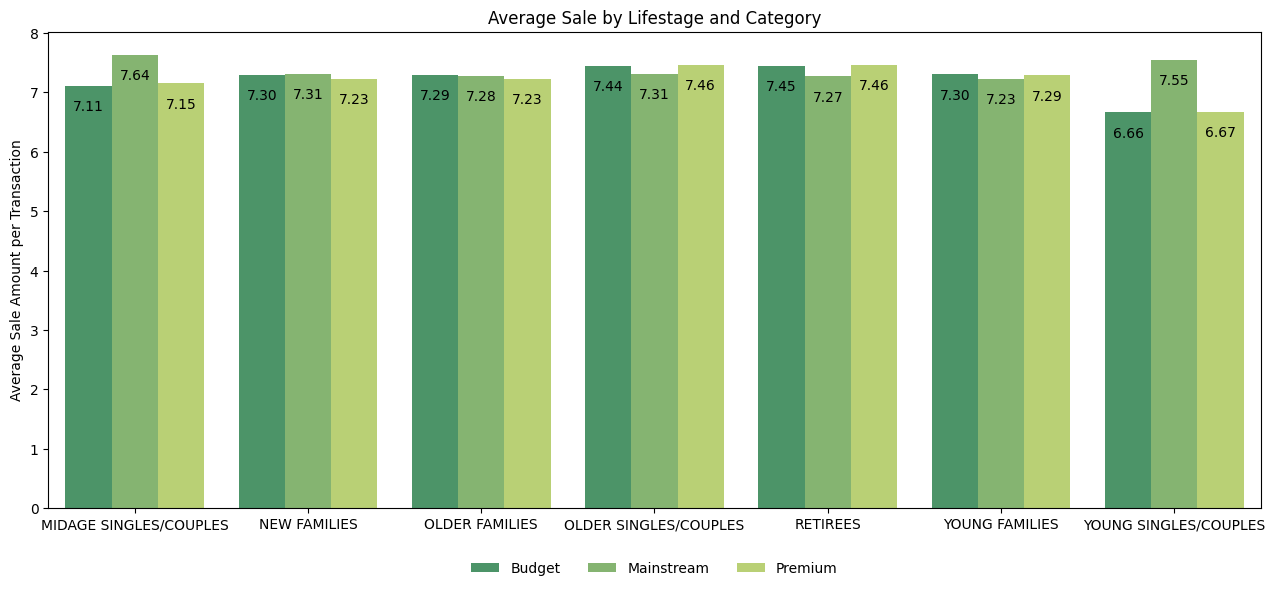

In [68]:
fig, ax = plt.subplots(figsize=(13, 6))

sns.barplot(
    data=trans_lifestage_cat, 
    x="LIFESTAGE", 
    y="MEAN_SALES", 
    hue="PREMIUM_CUSTOMER", 
    palette="summer", 
    ax=ax
)
ax.legend(
    bbox_to_anchor=(0.5, -0.10),
    loc="upper center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)
ax.set_xlabel("")
ax.set_ylabel("Average Sale Amount per Transaction")
ax.set_title("Average Sale by Lifestage and Category")
for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f"{x:.2f}", padding=-20)


fig.tight_layout()
fig.savefig("./static/mean_sales.jpg", bbox_inches="tight")

In [69]:
(
    df_main.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])
        .apply(lambda x: (x["TOT_SALES"].sum() / x["PROD_QTY"].sum()).round(4), include_groups=False)
        .reset_index(name="AVG_SALES_PER_PACK")
)

,LIFESTAGE,PREMIUM_CUSTOMER,AVG_SALES_PER_PACK
0,MIDAGE SINGLES/COUPLES,Budget,3.7539
1,MIDAGE SINGLES/COUPLES,Mainstream,3.9944
2,MIDAGE SINGLES/COUPLES,Premium,3.7808
3,NEW FAMILIES,Budget,3.9320
4,NEW FAMILIES,Mainstream,3.9359
5,NEW FAMILIES,Premium,3.8862
6,OLDER FAMILIES,Budget,3.7480
7,OLDER FAMILIES,Mainstream,3.7364
8,OLDER FAMILIES,Premium,3.7177
9,OLDER SINGLES/COUPLES,Budget,3.8875


**Remarks**
+ Considering both lifestage and category based on average sales per transaction (total sales / total transaction) and average sales per product quantity (total sales / product quantity), `OLDER SINGLES/COUPLES` and `RETIREES` generally have slightly high values compared to other lifestages for all categories.
+ More interesting, Mainstream `MIDAGE SINGLES/COUPLES` and `YOUNG SINGLES/COUPLES` have higher averages than their counterparts in other categories (i.e. Budget and Premium) and even to Mainstream `OLDER SINGLES/COUPLES` and `RETIREES`. This means they are willing to buy more chips per transaction.
+ We can check if this difference is statistically significant.

In [70]:
# Check statistical significance between mean sales of Retirees and Midage Singles/Couples

target_lifestage = ["MIDAGE SINGLES/COUPLES", "YOUNG SINGLES/COUPLES"]

df_ttest = df_main[df_main["LIFESTAGE"].isin(target_lifestage)]

group_1 = df_ttest[df_ttest["PREMIUM_CUSTOMER"] == "Mainstream"]["PROD_UPRICE"]
group_2 = df_ttest[df_ttest["PREMIUM_CUSTOMER"] != "Mainstream"]["PROD_UPRICE"]

print(group_1.shape, group_2.shape)
print(group_1.mean(), group_2.mean())

ttest_ind(group_1, group_2, equal_var=False, alternative="greater")

(30639,) (26728,)
4.039785893795489 3.706491319964083


TtestResult(statistic=np.float64(37.6243885962295), pvalue=np.float64(3.4836771165090696e-306), df=np.float64(54791.093927403155))

+ p-value is very small, way less than 0.05 assuming a 5% significance level. This means we have good confidence that Mainstream `MIDAGE SINGLES/COUPLES` and `YOUNG SINGLES/COUPLES` are willing to buy more chips per transaction than their counterparts in other customer categories.
+ We could be a little pedantic and try doing the test for each of the lifestages we're looking on, but we get similar results as shown below.

In [77]:
df_ttest = df_main[df_main["LIFESTAGE"] == "MIDAGE SINGLES/COUPLES"]

group_1 = df_ttest[df_ttest["PREMIUM_CUSTOMER"] == "Mainstream"]["PROD_UPRICE"]
group_2 = df_ttest[df_ttest["PREMIUM_CUSTOMER"] != "Mainstream"]["PROD_UPRICE"]

print(group_1.shape, group_2.shape)
print(group_1.mean(), group_2.mean())

ttest_ind(group_1, group_2, equal_var=False, alternative="greater")

(11095,) (12303,)
3.9942406489409636 3.7602617247825734


TtestResult(statistic=np.float64(16.864135225719963), pvalue=np.float64(9.811433644745379e-64), df=np.float64(23344.921688938157))

In [78]:
df_ttest = df_main[df_main["LIFESTAGE"] == "YOUNG SINGLES/COUPLES"]

group_1 = df_ttest[df_ttest["PREMIUM_CUSTOMER"] == "Mainstream"]["PROD_UPRICE"]
group_2 = df_ttest[df_ttest["PREMIUM_CUSTOMER"] != "Mainstream"]["PROD_UPRICE"]

print(group_1.shape, group_2.shape)
print(group_1.mean(), group_2.mean())

ttest_ind(group_1, group_2, equal_var=False, alternative="greater")

(19544,) (14425,)
4.065641629144494 3.660630849220104


TtestResult(statistic=np.float64(34.83507679311389), pvalue=np.float64(7.3927611974773405e-261), df=np.float64(29326.25582648687))

Let's explore other things, such as how much pack of chips and how much sales an individual can do in a single transaction.

In [ ]:
# grouped_total_sales = df_main.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"].sum().unstack("PREMIUM_CUSTOMER").round(3)

# fig, ax = plt.subplots(figsize=(13, 8))

# grouped_total_sales.plot.barh(
#     xlabel="Total Sales",
#     ylabel="Customer Lifestages",
#     colormap="summer",
#     width=0.8,
#     ax=ax
# )
# ax.legend(
#     bbox_to_anchor=(0.5, 1.02),
#     loc="lower center",
#     borderaxespad=0,
#     frameon=False,
#     ncol=3,
# )
# for container in ax.containers:
#     ax.bar_label(container, padding=-45)


# fig.tight_layout()

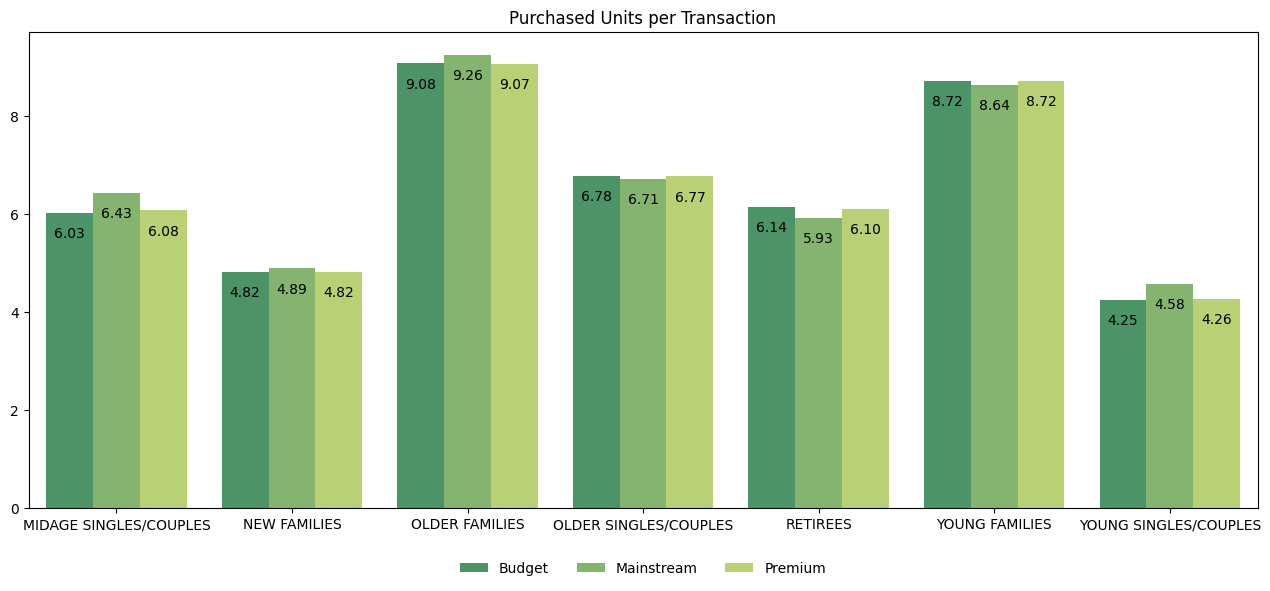

In [72]:
# Visualize how much pack of chips bought in a single transaction a person can do

avg_purc_units = (
    df_main.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])
        .apply(lambda x: x["PROD_QTY"].sum() / x["LYLTY_CARD_NBR"].nunique(), include_groups=False)
        .reset_index(name="AVG_UNITS")
)

fig, ax = plt.subplots(figsize=(13, 6))

sns.barplot(
    data=avg_purc_units, 
    x="LIFESTAGE", 
    y="AVG_UNITS", 
    hue="PREMIUM_CUSTOMER", 
    palette="summer", 
    ax=ax
)
ax.legend(
    bbox_to_anchor=(0.5, -0.10),
    loc="upper center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Purchased Units per Transaction")
for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f"{x:.2f}", padding=-20)


fig.tight_layout()
fig.savefig("./static/mean_purc_units.jpg", bbox_inches="tight")

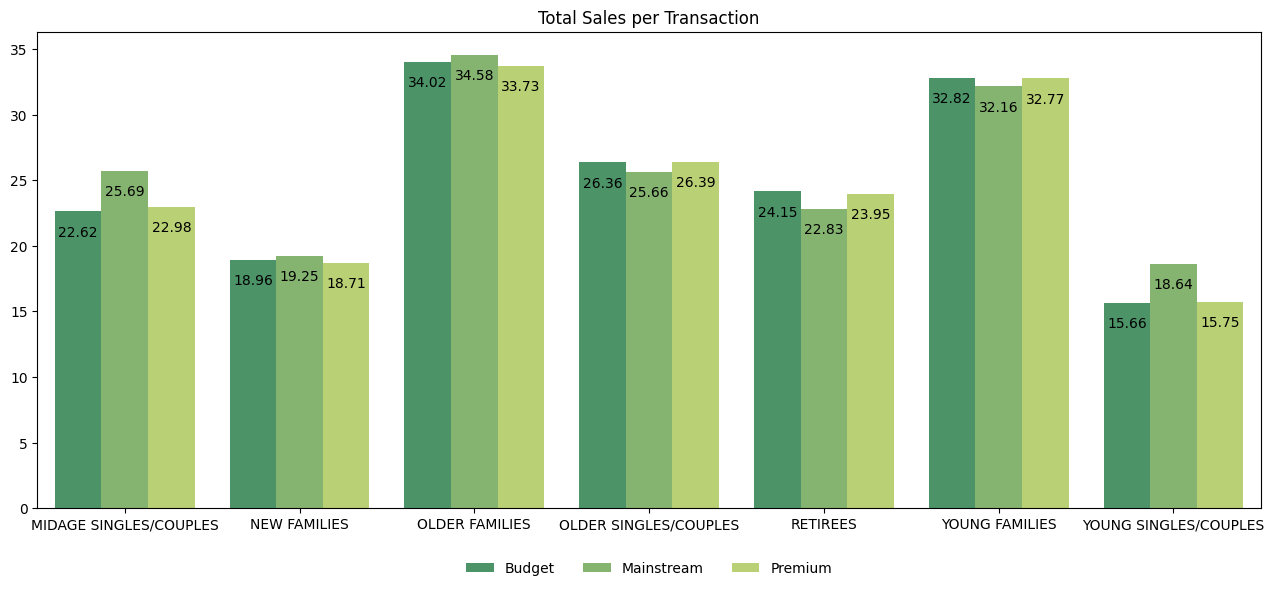

In [73]:
# Visualize how much sale in a single transaction a person can make

avg_purc_sales = (
    df_main.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])
        .apply(lambda x: x["TOT_SALES"].sum() / x["LYLTY_CARD_NBR"].nunique(), include_groups=False)
        .reset_index(name="AVG_SALES")
)

fig, ax = plt.subplots(figsize=(13, 6))

sns.barplot(
    data=avg_purc_sales, 
    x="LIFESTAGE", 
    y="AVG_SALES", 
    hue="PREMIUM_CUSTOMER", 
    palette="summer", 
    ax=ax
)
ax.legend(
    bbox_to_anchor=(0.5, -0.10),
    loc="upper center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Total Sales per Transaction")
for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f"{x:.2f}", padding=-20)


fig.tight_layout()
fig.savefig("./static/mean_purc_units.jpg", bbox_inches="tight")

**Remarks**
+ An individual from `OLDER FAMILIES` or `YOUNG FAMILIES` are willing to buy more in a single transaction for all categories.

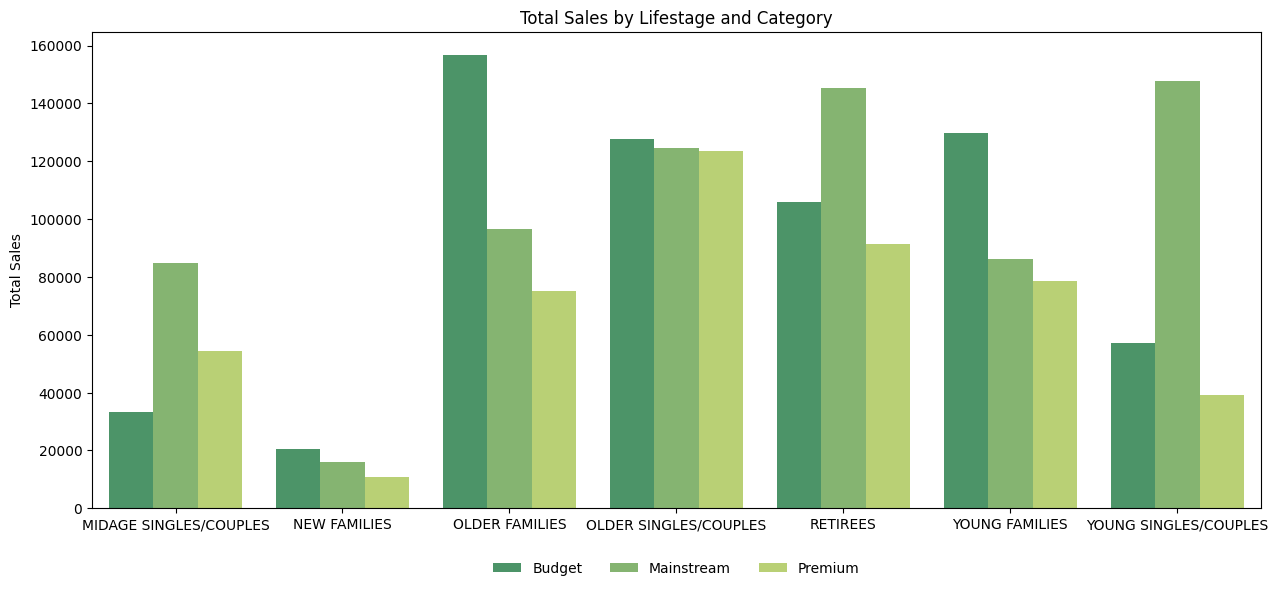

In [74]:
# Visualize total sales made by lifestage and category

fig, ax = plt.subplots(figsize=(13, 6))

sns.barplot(
    data=trans_lifestage_cat, 
    x="LIFESTAGE", 
    y="SUM_SALES", 
    hue="PREMIUM_CUSTOMER",
    palette="summer",
    ax=ax
)
ax.legend(
    bbox_to_anchor=(0.5, -0.10),
    loc="upper center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)
ax.set_xlabel("")
ax.set_ylabel("Total Sales")
ax.set_title("Total Sales by Lifestage and Category")
# for container in ax.containers:
#     ax.bar_label(
#         container, 
#         fmt=lambda x: f"{x:.2f}", 
#         padding=5,
#         rotation=90
#     )


fig.tight_layout()
fig.savefig("./static/total_sales.jpg", bbox_inches="tight")

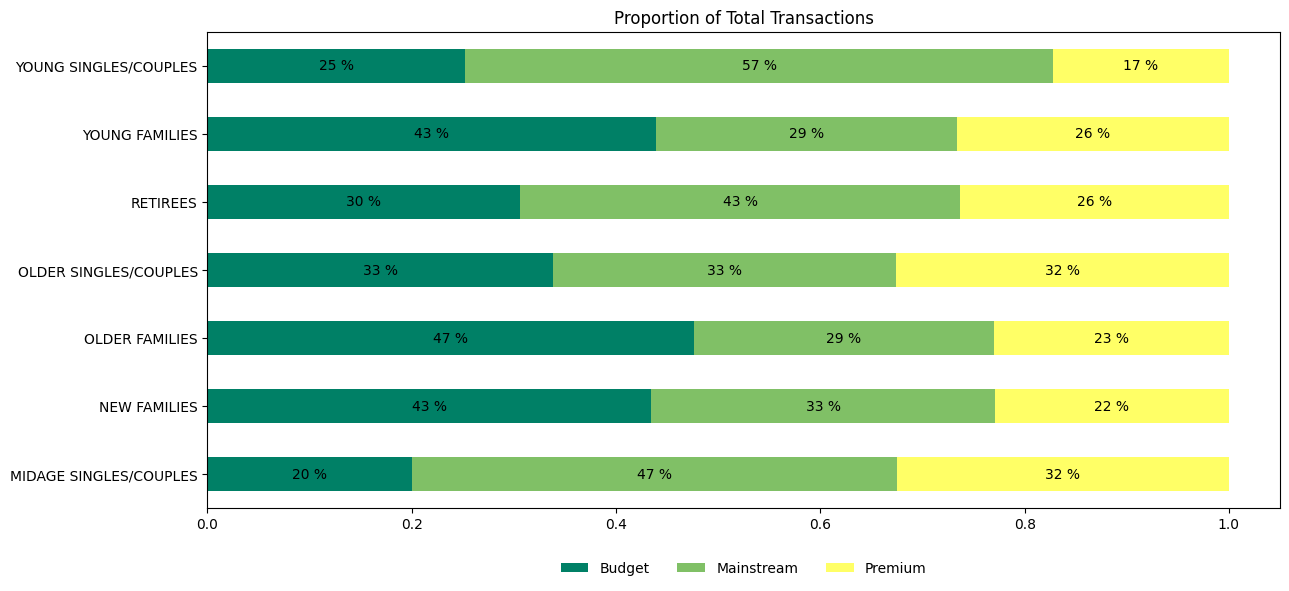

In [75]:
# Visualize proportion of transactions for every lifestage and category

x_var, y_var = "LIFESTAGE", "PREMIUM_CUSTOMER"
grouped_transactions = df_main.groupby(x_var)[y_var].value_counts(normalize=True).unstack(y_var)

fig, ax = plt.subplots(figsize=(13, 6))

grouped_transactions.plot.barh(
    stacked=True, 
    xlabel="",
    ylabel="Customer Lifestages",
    title="Proportion of Total Transactions",
    colormap="summer",
    ax=ax
)
ax.legend(
    bbox_to_anchor=(0.5, -0.10),
    loc="upper center",
    borderaxespad=0,
    frameon=False,
    ncol=3,
)
ax.set_ylabel("")
for ix, row in grouped_transactions.reset_index(drop=True).iterrows():
    cumulative = 0
    for element in row:
        if element == element and element > 0.1:
            ax.text(
                cumulative + element / 2,
                ix,
                f"{int(element * 100)} %",
                va="center",
                ha="center",
            )
            cumulative += element


fig.tight_layout()
fig.savefig("./static/percent_trans.jpg", bbox_inches="tight")

**Remarks**
+ Top spenders by Lifestage and Category
    + `MIDAGE SINGLES/COUPLES` -> Mainstream
    + `NEW FAMILIES` -> Budget
    + `OLDER FAMILIES` -> Budget
    + `OLDER SINGLES/COUPLES` -> Budget
    + `RETIREES` -> Mainstream
    + `YOUNG FAMILIES` -> Budget
    + `YOUNG SINGLES/COUPLES` -> Mainstream
+ Interesting insight by total sales alone, Budget `OLDER FAMILIES` and `YOUNG FAMILIES` are at the top in their respective lifestage.
+ Suppose we're going to narrow our focus based on insights from sales and transactions. Based on the *Purchased Units per Transaction*, *Total Sales per Transaction*, *Total Sales by Lifestage and Category* and given what we have learned prior, we should look into the following.
    + Mainstream `MIDAGE SINGLES/COUPLES` and `YOUNG SINGLES/COUPLES`
    + All `OLDER SINGLES/COUPLES`
    + Mainstream `RETIREES`
    + Budget `OLDER FAMILIES`
+ If the company wants to plan something for Budget customers, we should look into `OLDER FAMILIES` and `YOUNG FAMILIES`, judging the total transactions and total sales.

## Potato chip purchases

As a start, create histogram for distribution of potato chip purchases by pack size

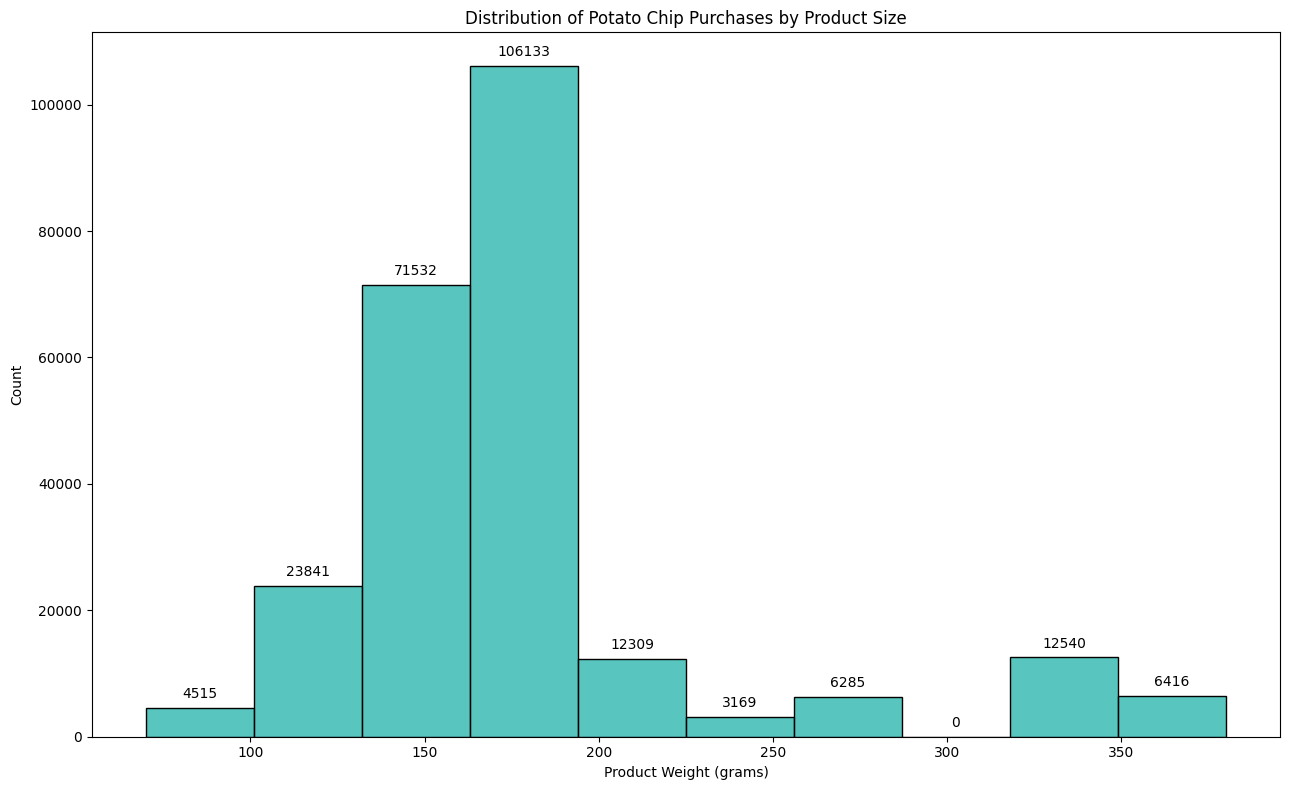

In [73]:
fig, ax = plt.subplots(figsize=(13, 8))

sns.histplot(
    data=df_main, 
    x="PROD_WT", 
    bins=10, 
    color="lightseagreen"
)

ax.bar_label(ax.containers[0], padding=5)
ax.set_xlabel("Product Weight (grams)")
ax.set_title("Distribution of Potato Chip Purchases by Product Size")

fig.tight_layout()

Most of the purchases made lies between 150g and 200g product size.

In [76]:
pack_size_pareto = df_main.groupby("PROD_WT")["TOT_SALES"].sum().sort_values(ascending=False).to_frame()
pack_size_pareto["PERCENT_SALE"] = pack_size_pareto["TOT_SALES"] / pack_size_pareto["TOT_SALES"].sum() * 100
pack_size_pareto["CUMSUM"] = pack_size_pareto["TOT_SALES"].cumsum() / pack_size_pareto["TOT_SALES"].sum() * 100
pack_size_pareto.index = pack_size_pareto.index.map(str)

pack_size_pareto.round(2)

,TOT_SALES,PERCENT_SALE,CUMSUM
PROD_WT,,,
175,485437.4,26.89,26.89
150,289681.8,16.05,42.94
134,177655.5,9.84,52.78
110,162765.4,9.02,61.80
170,146673.0,8.13,69.92
330,136794.3,7.58,77.50
165,101360.6,5.61,83.11
380,75419.6,4.18,87.29
270,55425.4,3.07,90.36


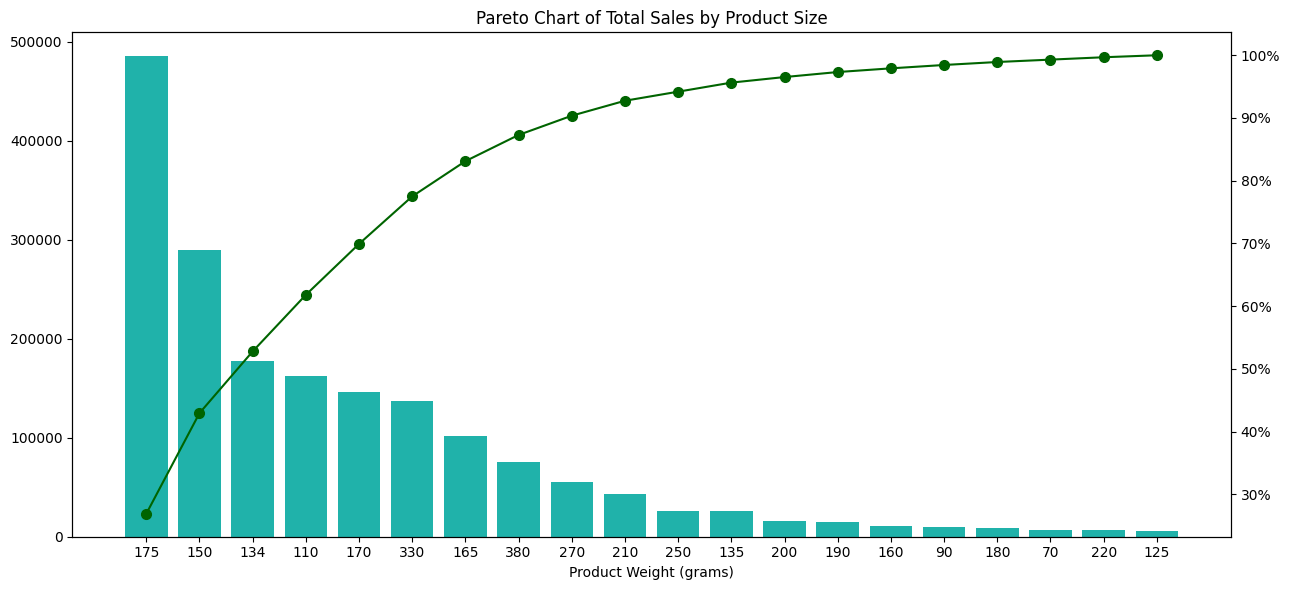

In [77]:
# Checking Pareto Chart of Total Sales by Product Size

fig, ax = plt.subplots(figsize=(13, 6))


ax.bar(pack_size_pareto.index, pack_size_pareto["TOT_SALES"], color="lightseagreen")
ax2 = ax.twinx()
ax2.plot(pack_size_pareto.index, pack_size_pareto["CUMSUM"], color="darkgreen", marker="o", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y")
ax2.tick_params(axis="y")

ax.set_xlabel("Product Weight (grams)")
ax.set_title("Pareto Chart of Total Sales by Product Size")


fig.tight_layout()

In [78]:
trans_prod_wt = pd.pivot_table(data=df_main, values="TOT_SALES", index="PROD_WT", aggfunc=["sum", "count", "mean", "median"])
trans_prod_wt.columns = [f"{col[0]}_sales".upper() for col in trans_prod_wt.columns]
trans_prod_wt["PERCENT_SALES"] = trans_prod_wt["SUM_SALES"] / trans_prod_wt["SUM_SALES"].sum() * 100

trans_prod_wt.sort_values(by="SUM_SALES", ascending=False).round(2)

,SUM_SALES,COUNT_SALES,MEAN_SALES,MEDIAN_SALES,PERCENT_SALES
PROD_WT,,,,,
175,485437.4,66390,7.31,6.6,26.89
150,289681.8,40203,7.21,7.8,16.05
134,177655.5,25102,7.08,7.4,9.84
110,162765.4,22387,7.27,7.6,9.02
170,146673.0,19983,7.34,8.8,8.13
330,136794.3,12540,10.91,11.4,7.58
165,101360.6,15297,6.63,6.0,5.61
380,75419.6,6416,11.75,11.8,4.18
270,55425.4,6285,8.82,9.2,3.07


**Remarks**
+ Top pack sizes contributing 80% of total sales:
  + **175g (26.89%)**
  + **150g (16.05%)**
  + **134g (9.84%)**
  + 110g
  + 170g
  + 330g
  + 165g
+ As expected, product with large pack sizes generally make large sale amount per transaction (mean).

In [79]:
trans_prod_name = pd.pivot_table(data=df_main, values="TOT_SALES", index="PROD_NAME", aggfunc=["count", "sum", "mean"])
trans_prod_name.columns = [f"{col[0]}_sales".upper() for col in trans_prod_name.columns]
trans_prod_name["PERCENT_SALES"] = trans_prod_name["SUM_SALES"] / trans_prod_name["SUM_SALES"].sum() * 100

In [80]:
# Top 10 products with the most sales made

trans_prod_name.sort_values(by="SUM_SALES", ascending=False).round(2).head(10)

,COUNT_SALES,SUM_SALES,MEAN_SALES,PERCENT_SALES
PROD_NAME,,,,
Doritos Corn Chp Supreme,3183,39052.0,12.27,2.16
Smiths Crnkle Chip Orgnl Big Bag,3233,36367.6,11.25,2.01
Smiths Crinkle Chips Salt Vinegar,3197,34804.2,10.89,1.93
Kettle Mozzarella Basil Pesto,3304,34457.4,10.43,1.91
Smiths Crinkle Original,3142,34302.6,10.92,1.90
Cheezels Cheese,3149,34296.9,10.89,1.90
Doritos Cheese Supreme,3052,33390.6,10.94,1.85
Kettle Sweet Chilli And Sour Cream,3200,33031.8,10.32,1.83
Kettle Original,3159,32740.2,10.36,1.81


In [81]:
# Top 10 products with the least sales made

trans_prod_name.sort_values(by="SUM_SALES").round(2).head(10)

,COUNT_SALES,SUM_SALES,MEAN_SALES,PERCENT_SALES
PROD_NAME,,,,
,0,0.0,NaN,0.00
Woolworths Crinkle Cut Original,1410,4532.2,3.21,0.25
Sunbites Whlegrn Crisps Frch Onin,1432,4600.2,3.21,0.25
Woolworths Crinkle Cut Chicken,1467,4702.2,3.21,0.26
Sunbites Whlgrn Crisps Cheddr Mstrd,1576,5076.2,3.22,0.28
Woolworths Cheese Rings,1516,5169.6,3.41,0.29
Woolworths D Style Chip Sea Salt,1469,5249.7,3.57,0.29
Woolworths Sour Cream Onionstacked Chips,1483,5323.8,3.59,0.29
Woolworths Original Stacked Chips,1487,5323.8,3.58,0.29


In [82]:
# Check product size of top products

top_products = trans_prod_name.sort_values(by="SUM_SALES", ascending=False).head(10).index

(
    df_main[df_main["PROD_NAME"].isin(top_products)]
        .groupby(["PROD_NAME", "PROD_WT"])["TOT_SALES"]
        .sum()
        .sort_values(ascending=False)
)

PROD_NAME                           PROD_WT
Doritos Corn Chp Supreme            380        39052.0
Smiths Crnkle Chip Orgnl Big Bag    380        36367.6
Smiths Crinkle Chips Salt Vinegar   330        34804.2
Kettle Mozzarella Basil Pesto       175        34457.4
Smiths Crinkle Original             330        34302.6
Cheezels Cheese                     330        34296.9
Doritos Cheese Supreme              330        33390.6
Kettle Sweet Chilli And Sour Cream  175        33031.8
Kettle Original                     175        32740.2
Kettle Sea Salt And Vinegar         175        32589.0
Name: TOT_SALES, dtype: float64

In [83]:
# Check product brands based on the top three product size in terms of sales

top_pack_sizes = [175, 150, 134]

(
    df_main[df_main["PROD_WT"].isin(top_pack_sizes)]
        .groupby(["PROD_BRAND", "PROD_WT"])["TOT_SALES"]
        .sum()
        .sort_values(ascending=False)
)

PROD_BRAND  PROD_WT
KETTLE      175        196668.0
PRINGLES    134        177655.5
KETTLE      150        167481.4
THINS       175         88852.5
TOSTITOS    175         79789.6
DORITOS     150         47622.9
RRD         150         45535.5
SMITHS      175         42567.0
NATURAL     175         42318.0
SMITHS      150         29042.0
CCS         175         18078.9
WOOLWORTHS  175          9234.4
FRENCH      175          7929.0
Name: TOT_SALES, dtype: float64

In [84]:
# Check product brands that has large size

df_main[df_main["PROD_WT"] >= 200].groupby(["PROD_BRAND", "PROD_WT"])["TOT_SALES"].sum().sort_values(ascending=False)

PROD_BRAND  PROD_WT
SMITHS      330        69106.8
TWISTIES    270        55425.4
GRNWVES     210        43048.8
DORITOS     380        39052.0
SMITHS      380        36367.6
CHEEZELS    330        34296.9
DORITOS     330        33390.6
TWISTIES    250        26096.7
WOOLWORTHS  200        16007.5
BURGER      220         6831.0
Name: TOT_SALES, dtype: float64

In [85]:
# Check total sales of each product brands

df_main.groupby("PROD_BRAND")["TOT_SALES"].sum().sort_values(ascending=False)

PROD_BRAND
KETTLE        390239.8
DORITOS       226329.9
SMITHS        217492.0
PRINGLES      177655.5
INFUZIONS      99047.6
THINS          88852.5
RRD            87607.5
TWISTIES       81522.1
TOSTITOS       79789.6
COBS           70569.8
TYRRELLS       51647.4
GRNWVES        51617.2
NATURAL        42318.0
WOOLWORTHS     41059.1
CHEEZELS       40029.9
CCS            18078.9
CHEETOS        16884.5
SUNBITES        9676.4
FRENCH          7929.0
BURGER          6831.0
Name: TOT_SALES, dtype: float64

**Remarks**
+ Top brands: **Kettle, Doritos, Smiths, Pringles, Infuzions**
+ Notable product to mention: **Cheezels Cheese**

In [104]:
df_main.groupby("PROD_WT")["PROD_NAME"].nunique().sort_values(ascending=False)

PROD_WT
175    30
150    18
170     9
134     8
165     8
110     7
330     4
200     3
380     2
270     2
90      2
160     2
210     2
190     2
125     1
70      1
180     1
135     1
220     1
250     1
Name: PROD_NAME, dtype: int64

In [108]:
df_main[df_main["PROD_WT"] == 175]["PROD_NAME"].unique()

array(['Ccs Tasty Cheese', 'Kettle Mozzarella Basil Pesto',
       'Thins Chips Light Tangy', 'Thins Potato Chips Hot Spicy',
       'Tostitos Lightly Salted', 'Kettle Sweet Chilli And Sour Cream',
       'Kettle Original', 'Ccs Original', 'Kettle Honey Soy Chicken',
       'Smiths Chip Thinly Cut Original', 'Kettle Sea Salt And Vinegar',
       'Natural Chipco Sea Salt Vinegr', 'Ccs Nacho Cheese',
       'Tostitos Splash Of Lime', 'Kettle Chilli',
       'Smiths Thinly Swt Chli S Cream', 'Thins Chips Salt Vinegar',
       'Thins Chips Seasonedchicken', 'French Fries Potato Chips',
       'Natural Sour Cream Garden Chives',
       'Smiths Thinly Cut Roast Chicken',
       'Woolworths Crinkle Cut Chicken',
       'Smiths Chip Thinly S Cream Onion',
       'Smiths Chip Thinly Cutsalt Vinegr',
       'Natural Chip Co Tmato Hrb Spce', 'Tostitos Smoked Chipotle',
       'Woolworths Crinkle Cut Original', 'Thins Chips Originl Saltd',
       'Natural Chip Compny Seasalt', 'Natural Chipco Hony

In [109]:
df_main[df_main["PROD_WT"] == 150]["PROD_NAME"].unique()

array(['Rrd Rock Deli Thai Chilli Lime',
       'Smiths Crinkle Cut French Oniondip',
       'Kettle Tortilla Chpsbtroot Ricotta',
       'Rrd Rock Deli Chikn Garlic Aioli', 'Rrd Steak Chimuchurri',
       'Kettle Sensations Camembert Fig', 'Kettle Sensations Bbq Maple',
       'Kettle Sensations Siracha Lime',
       'Doritos Corn Chip Mexican Jalapeno',
       'Smiths Crinkle Cut Mac N Cheese', 'Smiths Crinkle Cut Bolognese',
       'Doritos Corn Chip Southern Chicken',
       'Kettle Tortilla Chpshny Jlpno Chili',
       'Rrd Sr Slow Rst Pork Belly', 'Kettle Tortilla Chpsfeta Garlic',
       'Rrd Rock Deli Sp Salt Truffle', 'Smiths Crinkle Cut Snag Sauce',
       'Rrd Chilli Coconut'], dtype=object)

## Purchase trends

In [126]:
sales_trend = df_main.groupby("DATE")["TOT_SALES"].sum()
sales_trend.head()

DATE
2018-07-01    4920.1
2018-07-02    4877.0
2018-07-03    4954.7
2018-07-04    4968.1
2018-07-05    4682.0
Name: TOT_SALES, dtype: float64

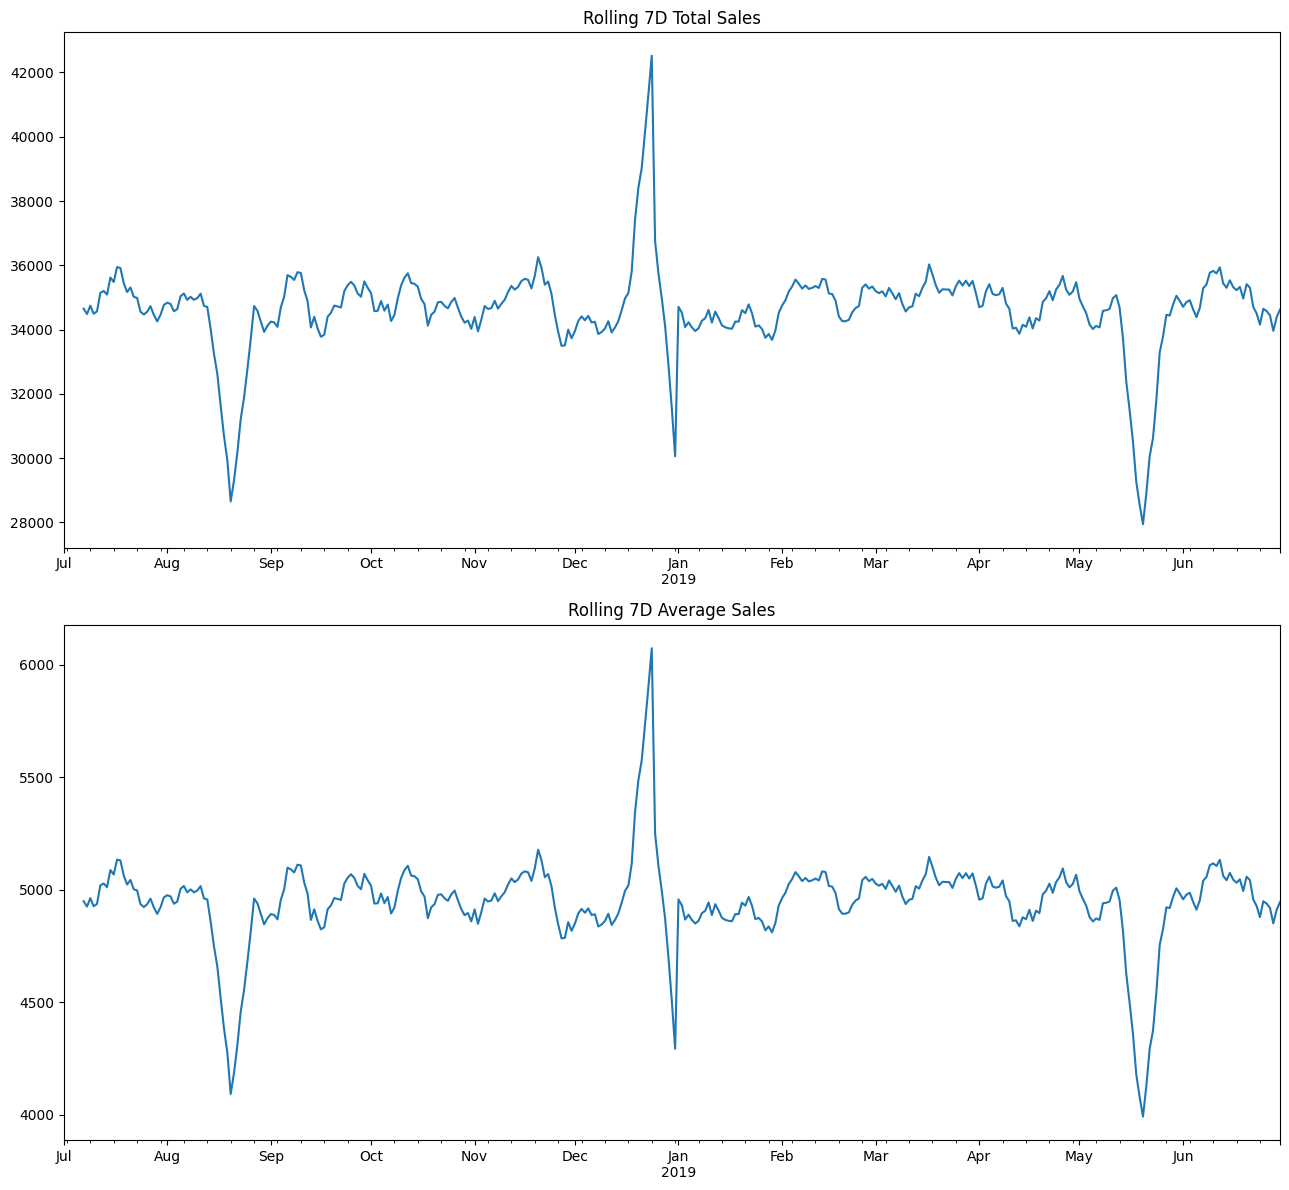

In [127]:
# Plot Rolling 7D Total and Average Sales

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13, 12))


sales_trend.rolling(7).sum().plot(
    kind="line",
    xlabel="",
    title="Rolling 7D Total Sales",
    ax=ax[0]
)

sales_trend.rolling(7).mean().plot(
    kind="line", 
    xlabel="",
    title="Rolling 7D Average Sales",
    ax=ax[1]
)


fig.tight_layout()

In [128]:
sales_trend["2018-08-01":"2018-08-31"]

DATE
2018-08-01    4992.80
2018-08-02    4842.50
2018-08-03    4969.80
2018-08-04    4823.10
2018-08-05    5191.90
2018-08-06    5259.60
2018-08-07    4844.10
2018-08-08    5087.70
2018-08-09    4750.30
2018-08-10    5023.50
2018-08-11    4961.70
2018-08-12    4811.10
2018-08-13    5224.00
2018-08-14    4163.45
2018-08-15    4311.50
2018-08-16    4125.30
2018-08-17    4036.55
2018-08-18    4016.70
2018-08-19    4058.15
2018-08-20    3941.00
2018-08-21    4823.60
2018-08-22    5171.10
2018-08-23    5168.20
2018-08-24    4705.10
2018-08-25    4899.00
2018-08-26    4991.40
2018-08-27    4974.00
2018-08-28    4675.70
2018-08-29    4847.10
2018-08-30    4837.10
2018-08-31    4895.00
Name: TOT_SALES, dtype: float64

In [129]:
sales_trend["2019-05-01":"2019-05-31"]

DATE
2019-05-01    4657.40
2019-05-02    4877.10
2019-05-03    4904.80
2019-05-04    4633.00
2019-05-05    4881.10
2019-05-06    5150.00
2019-05-07    4963.60
2019-05-08    5174.40
2019-05-09    4894.90
2019-05-10    4943.10
2019-05-11    4971.90
2019-05-12    4972.80
2019-05-13    4761.60
2019-05-14    4023.55
2019-05-15    3815.80
2019-05-16    4001.05
2019-05-17    3973.25
2019-05-18    3705.70
2019-05-19    4273.25
2019-05-20    4153.25
2019-05-21    4979.70
2019-05-22    4970.90
2019-05-23    4571.80
2019-05-24    5153.30
2019-05-25    5188.20
2019-05-26    4771.00
2019-05-27    4825.20
2019-05-28    4957.30
2019-05-29    5315.40
2019-05-30    4841.20
2019-05-31    4994.80
Name: TOT_SALES, dtype: float64

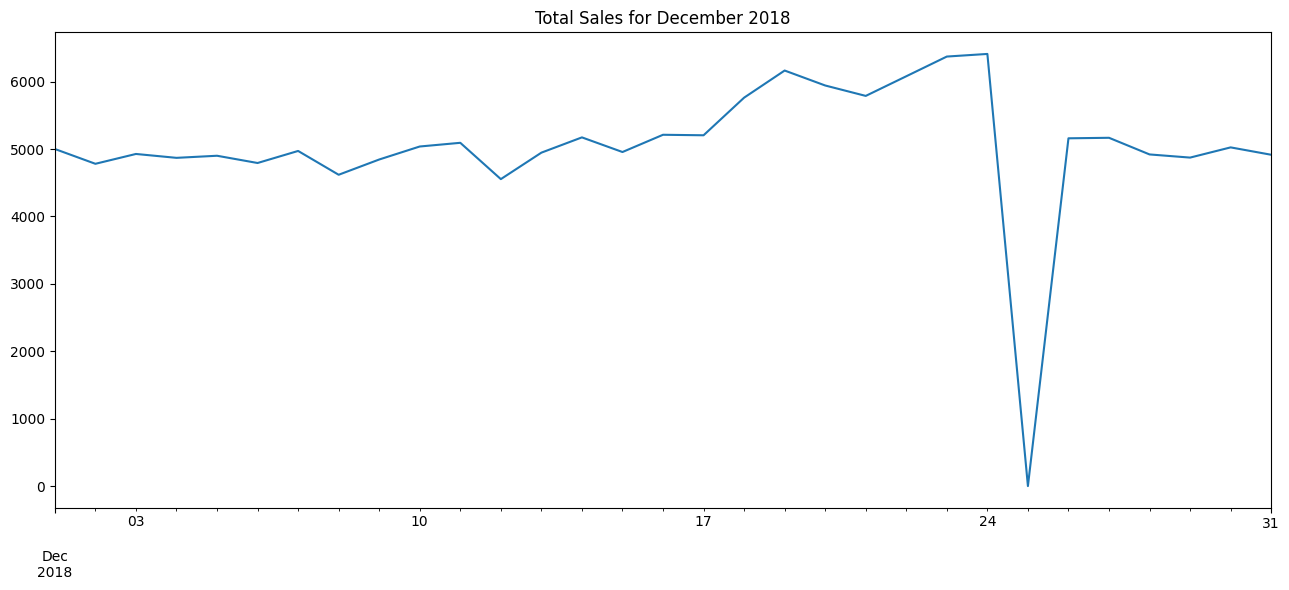

In [130]:
fig, ax = plt.subplots(figsize=(13, 6))

sales_trend["2018-12-01":"2018-12-31"].plot(
    kind="line",
    xlabel="",
    title="Total Sales for December 2018",
    ax=ax
)

fig.tight_layout()

In [131]:
sales_trend_trans = df_main["DATE"].value_counts().sort_index()
sales_trend_trans

DATE
2018-07-01    663
2018-07-02    650
2018-07-03    674
2018-07-04    669
2018-07-05    660
             ... 
2019-06-26    657
2019-06-27    669
2019-06-28    673
2019-06-29    703
2019-06-30    704
Name: count, Length: 365, dtype: int64

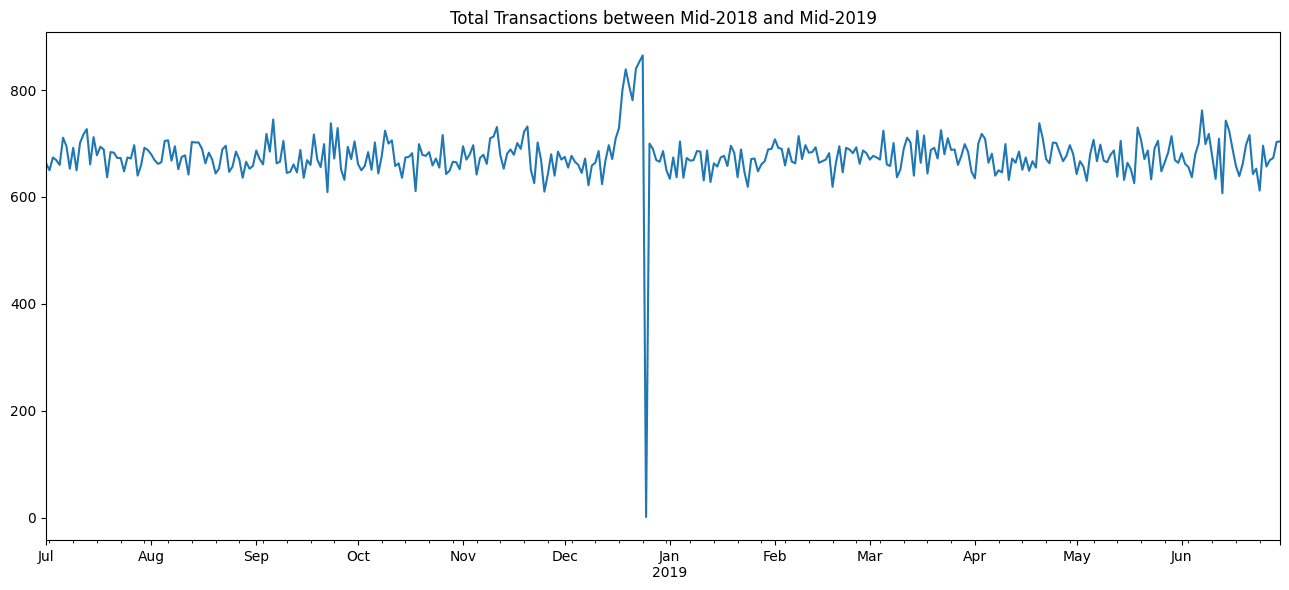

In [132]:
fig, ax = plt.subplots(figsize=(13, 6))

# sales_trend_trans.rolling(7).sum().plot(
#     kind="line",
#     xlabel="",
#     title="Rolling 7D Total Transactions",
#     ax=ax
# )

sales_trend_trans.plot(
    kind="line",
    xlabel="",
    title="Total Transactions between Mid-2018 and Mid-2019",
    ax=ax
)

fig.tight_layout()

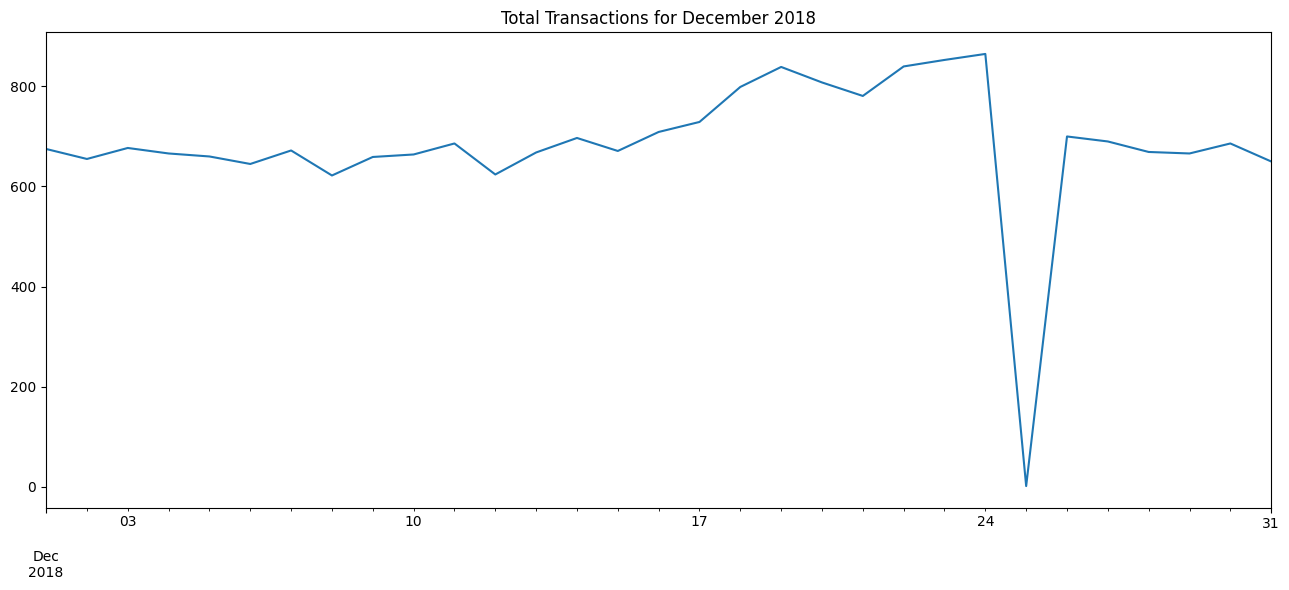

In [133]:
fig, ax = plt.subplots(figsize=(13, 6))

sales_trend_trans["2018-12-01":"2018-12-31"].plot(
    kind="line",
    xlabel="",
    title="Total Transactions for December 2018",
    ax=ax
)

fig.tight_layout()

**Remarks**
+ The top period for sale based on total transactions and sales occured in the month of December (2018), notably in the week before Christmas.
+ Note that there are no records on Christmas day as the stores were closed in that day.
+ Total transactions are generally consistent all year round outside of the peak within December.
+ There is a noticeable dip in total sales during the month of August (2018) and May (2019).

## Further analysis

+ Based on our prior explorations on sales and transactions, we noticed that Mainstream customers surely has a large impact over our sales. We can try understanding their behavior by looking at what brand they tend to buy the most relative to other categories.
+ This approach is reasonable because this is the customer category we should look into for the following lifestages - `MIDAGE SINGLES/COUPLES`, `YOUNG SINGLES/COUPLES`, `OLDER SINGLES/COUPLES`, `RETIREES`

In [147]:
filter_condition = df_main["PREMIUM_CUSTOMER"] == "Mainstream"

segment_target, segment_other = df_main[filter_condition], df_main[~filter_condition]

# Total quantity of chips bought by each segment
total_qty_target, total_qty_other = segment_target["PROD_QTY"].sum(), segment_other["PROD_QTY"].sum()

# Get proportion of quantity by brand for the target and other segment
brand_prop_target = (segment_target.groupby("PROD_BRAND")["PROD_QTY"].sum() / total_qty_target).reset_index(name="PROP_TARGET")
brand_prop_other = (segment_other.groupby("PROD_BRAND")["PROD_QTY"].sum() / total_qty_other).reset_index(name="PROP_OTHER")

mainstream_brand_affinity = brand_prop_target.merge(brand_prop_other, on="PROD_BRAND")
mainstream_brand_affinity["AFFINITY_SCORE"] = mainstream_brand_affinity["PROP_TARGET"].div( mainstream_brand_affinity["PROP_OTHER"])

mainstream_brand_affinity.sort_values(by="AFFINITY_SCORE", ascending=False)

,PROD_BRAND,PROP_TARGET,PROP_OTHER,AFFINITY_SCORE
4,COBS,0.041288,0.03835,1.076593
5,DORITOS,0.106815,0.100204,1.065974
18,TYRRELLS,0.027099,0.025547,1.060745
17,TWISTIES,0.039861,0.037677,1.057953
9,KETTLE,0.173327,0.164758,1.052009
16,TOSTITOS,0.039484,0.037967,1.039964
11,PRINGLES,0.104331,0.100677,1.036296
7,GRNWVES,0.031856,0.030961,1.028908
8,INFUZIONS,0.058546,0.057092,1.025468
15,THINS,0.05754,0.057065,1.008323


**Remarks**
+ The top three products that Mainstream customers more likely to buy come from **Cobs, Doritos and Tyrrells**
+ We could drill this down into specific lifestages within Mainstream customers for a better idea.

In [149]:
# Consider Midage and Young Singles/Couples

lifestage_target = ["MIDAGE SINGLES/COUPLES", "YOUNG SINGLES/COUPLES"]
filter_condition = (df_main["PREMIUM_CUSTOMER"] == "Mainstream") & df_main["LIFESTAGE"].isin(lifestage_target)

segment_target, segment_other = df_main[filter_condition], df_main[~filter_condition]

# Total quantity of chips bought by each segment
total_qty_target, total_qty_other = segment_target["PROD_QTY"].sum(), segment_other["PROD_QTY"].sum()

# Get proportion of quantity by brand for the target and other segment
brand_prop_target = (segment_target.groupby("PROD_BRAND")["PROD_QTY"].sum() / total_qty_target).reset_index(name="PROP_TARGET")
brand_prop_other = (segment_other.groupby("PROD_BRAND")["PROD_QTY"].sum() / total_qty_other).reset_index(name="PROP_OTHER")

mainstream_brand_affinity = brand_prop_target.merge(brand_prop_other, on="PROD_BRAND")
mainstream_brand_affinity["AFFINITY_SCORE"] = mainstream_brand_affinity["PROP_TARGET"].div( mainstream_brand_affinity["PROP_OTHER"])

mainstream_brand_affinity.sort_values(by="AFFINITY_SCORE", ascending=False).head(5)

,PROD_BRAND,PROP_TARGET,PROP_OTHER,AFFINITY_SCORE
17,TWISTIES,0.045353,0.037565,1.207318
9,KETTLE,0.195985,0.164166,1.193826
16,TOSTITOS,0.044726,0.037691,1.186656
5,DORITOS,0.11764,0.100673,1.168535
18,TYRRELLS,0.029841,0.02563,1.164316


In [150]:
# Consider Older Singles/Couples

lifestage_target = ["OLDER SINGLES/COUPLES"]
filter_condition = (df_main["PREMIUM_CUSTOMER"] == "Mainstream") & df_main["LIFESTAGE"].isin(lifestage_target)

segment_target, segment_other = df_main[filter_condition], df_main[~filter_condition]

# Total quantity of chips bought by each segment
total_qty_target, total_qty_other = segment_target["PROD_QTY"].sum(), segment_other["PROD_QTY"].sum()

# Get proportion of quantity by brand for the target and other segment
brand_prop_target = (segment_target.groupby("PROD_BRAND")["PROD_QTY"].sum() / total_qty_target).reset_index(name="PROP_TARGET")
brand_prop_other = (segment_other.groupby("PROD_BRAND")["PROD_QTY"].sum() / total_qty_other).reset_index(name="PROP_OTHER")

mainstream_brand_affinity = brand_prop_target.merge(brand_prop_other, on="PROD_BRAND")
mainstream_brand_affinity["AFFINITY_SCORE"] = mainstream_brand_affinity["PROP_TARGET"].div( mainstream_brand_affinity["PROP_OTHER"])

mainstream_brand_affinity.sort_values(by="AFFINITY_SCORE", ascending=False).head(5)

,PROD_BRAND,PROP_TARGET,PROP_OTHER,AFFINITY_SCORE
19,WOOLWORTHS,0.050879,0.047223,1.077405
1,CCS,0.019597,0.018205,1.076464
4,COBS,0.04131,0.039343,1.050003
18,TYRRELLS,0.027325,0.026056,1.048729
14,SUNBITES,0.012543,0.012067,1.039441


In [151]:
# Consider Retirees

lifestage_target = ["RETIREES"]
filter_condition = (df_main["PREMIUM_CUSTOMER"] == "Mainstream") & df_main["LIFESTAGE"].isin(lifestage_target)

segment_target, segment_other = df_main[filter_condition], df_main[~filter_condition]

# Total quantity of chips bought by each segment
total_qty_target, total_qty_other = segment_target["PROD_QTY"].sum(), segment_other["PROD_QTY"].sum()

# Get proportion of quantity by brand for the target and other segment
brand_prop_target = (segment_target.groupby("PROD_BRAND")["PROD_QTY"].sum() / total_qty_target).reset_index(name="PROP_TARGET")
brand_prop_other = (segment_other.groupby("PROD_BRAND")["PROD_QTY"].sum() / total_qty_other).reset_index(name="PROP_OTHER")

mainstream_brand_affinity = brand_prop_target.merge(brand_prop_other, on="PROD_BRAND")
mainstream_brand_affinity["AFFINITY_SCORE"] = mainstream_brand_affinity["PROP_TARGET"].div( mainstream_brand_affinity["PROP_OTHER"])

mainstream_brand_affinity.sort_values(by="AFFINITY_SCORE", ascending=False).head(5)

,PROD_BRAND,PROP_TARGET,PROP_OTHER,AFFINITY_SCORE
7,GRNWVES,0.033389,0.031124,1.072779
15,THINS,0.060488,0.056965,1.061842
17,TWISTIES,0.040237,0.038366,1.048749
11,PRINGLES,0.106033,0.101737,1.042221
8,INFUZIONS,0.059612,0.05748,1.037085


**Remarks**
+ The Mainstream Midage and Young Singles/Couples seems to like Twisties the most.
+ The Mainstream Older Singles/Couples seems to like Woolworths the most.
+ The Mainstream Retirees seems to like Grnwves the most.

similarly we can check the affinity scores for Budget and Premium.

In [152]:
# Consider all budget customers

filter_condition = df_main["PREMIUM_CUSTOMER"] == "Budget"

segment_target, segment_other = df_main[filter_condition], df_main[~filter_condition]

# Total quantity of chips bought by each segment
total_qty_target, total_qty_other = segment_target["PROD_QTY"].sum(), segment_other["PROD_QTY"].sum()

# Get proportion of quantity by brand for the target and other segment
brand_prop_target = (segment_target.groupby("PROD_BRAND")["PROD_QTY"].sum() / total_qty_target).reset_index(name="PROP_TARGET")
brand_prop_other = (segment_other.groupby("PROD_BRAND")["PROD_QTY"].sum() / total_qty_other).reset_index(name="PROP_OTHER")

mainstream_brand_affinity = brand_prop_target.merge(brand_prop_other, on="PROD_BRAND")
mainstream_brand_affinity["AFFINITY_SCORE"] = mainstream_brand_affinity["PROP_TARGET"].div( mainstream_brand_affinity["PROP_OTHER"])

mainstream_brand_affinity.sort_values(by="AFFINITY_SCORE", ascending=False)

,PROD_BRAND,PROP_TARGET,PROP_OTHER,AFFINITY_SCORE
6,FRENCH,0.006117,0.005348,1.143842
14,SUNBITES,0.013018,0.011601,1.122106
19,WOOLWORTHS,0.050587,0.045784,1.104901
10,NATURAL,0.031796,0.029003,1.096316
0,BURGER,0.00663,0.006142,1.079377
1,CCS,0.019122,0.017855,1.071
12,RRD,0.068262,0.064259,1.062283
13,SMITHS,0.126395,0.120243,1.051164
2,CHEETOS,0.011986,0.011631,1.030566
3,CHEEZELS,0.01867,0.018554,1.006254


Top three for Budget category - **French, Sunbites, Woolworths**

In [155]:
# Consider all premium customers

filter_condition = df_main["PREMIUM_CUSTOMER"] == "Premium"

segment_target, segment_other = df_main[filter_condition], df_main[~filter_condition]

# Total quantity of chips bought by each segment
total_qty_target, total_qty_other = segment_target["PROD_QTY"].sum(), segment_other["PROD_QTY"].sum()

# Get proportion of quantity by brand for the target and other segment
brand_prop_target = (segment_target.groupby("PROD_BRAND")["PROD_QTY"].sum() / total_qty_target).reset_index(name="PROP_TARGET")
brand_prop_other = (segment_other.groupby("PROD_BRAND")["PROD_QTY"].sum() / total_qty_other).reset_index(name="PROP_OTHER")

mainstream_brand_affinity = brand_prop_target.merge(brand_prop_other, on="PROD_BRAND")
mainstream_brand_affinity["AFFINITY_SCORE"] = mainstream_brand_affinity["PROP_TARGET"].div( mainstream_brand_affinity["PROP_OTHER"])

mainstream_brand_affinity.sort_values(by="AFFINITY_SCORE", ascending=False)

,PROD_BRAND,PROP_TARGET,PROP_OTHER,AFFINITY_SCORE
0,BURGER,0.00671,0.006172,1.087133
19,WOOLWORTHS,0.049578,0.046726,1.061044
14,SUNBITES,0.012604,0.01192,1.057402
1,CCS,0.018895,0.01809,1.044504
3,CHEEZELS,0.019145,0.018398,1.040581
10,NATURAL,0.030813,0.029692,1.037733
12,RRD,0.067399,0.065052,1.036077
13,SMITHS,0.123404,0.122056,1.011046
16,TOSTITOS,0.038774,0.03847,1.007904
15,THINS,0.057402,0.057192,1.003685


Top three for Premium category - **Burger, Woolworths, Sunbites**

Going back to Mainstream customers, let's check affinity score in terms of product weights.

In [158]:
filter_condition = df_main["PREMIUM_CUSTOMER"] == "Mainstream"

segment_target, segment_other = df_main[filter_condition], df_main[~filter_condition]

# Total quantity of chips bought by each segment
total_qty_target, total_qty_other = segment_target["PROD_QTY"].sum(), segment_other["PROD_QTY"].sum()

# Get proportion of quantity by brand for the target and other segment
brand_prop_target = (segment_target.groupby("PROD_WT")["PROD_QTY"].sum() / total_qty_target).reset_index(name="PROP_TARGET")
brand_prop_other = (segment_other.groupby("PROD_WT")["PROD_QTY"].sum() / total_qty_other).reset_index(name="PROP_OTHER")

mainstream_brand_affinity = brand_prop_target.merge(brand_prop_other, on="PROD_WT")
mainstream_brand_affinity["AFFINITY_SCORE"] = mainstream_brand_affinity["PROP_TARGET"].div( mainstream_brand_affinity["PROP_OTHER"])

mainstream_brand_affinity.sort_values(by="AFFINITY_SCORE", ascending=False)

,PROD_WT,PROP_TARGET,PROP_OTHER,AFFINITY_SCORE
17,270,0.026795,0.024878,1.077077
5,135,0.01379,0.012841,1.073922
14,210,0.026458,0.024788,1.067365
19,380,0.027088,0.025468,1.063618
2,110,0.094369,0.088996,1.060369
18,330,0.052168,0.050301,1.037133
4,134,0.104331,0.100677,1.036296
16,250,0.013066,0.0128,1.020784
9,170,0.081823,0.080437,1.017237
6,150,0.163126,0.162876,1.001537


Some of the product size here are interesting, notably the ones that are more than 200g. We can look back into dataset which products has this product size.

In [166]:
df_main[df_main["PROD_WT"] == 270]["PROD_NAME"].value_counts()

PROD_NAME
Twisties Chicken    3170
Twisties Cheese     3115
Name: count, dtype: int64

In [167]:
df_main[df_main["PROD_WT"] == 135]["PROD_NAME"].value_counts()

PROD_NAME
Kettle Swt Pot Sea Salt    3257
Name: count, dtype: int64

In [168]:
df_main[df_main["PROD_WT"] == 210]["PROD_NAME"].value_counts()

PROD_NAME
Grnwves Waves Sweet Chilli         3167
Grnwves Waves Sour Cream Chives    3105
Name: count, dtype: int64

In [169]:
df_main[df_main["PROD_WT"] == 380]["PROD_NAME"].value_counts()

PROD_NAME
Smiths Crnkle Chip Orgnl Big Bag    3233
Doritos Corn Chp Supreme            3183
Name: count, dtype: int64

In [170]:
df_main[df_main["PROD_WT"] == 330]["PROD_NAME"].value_counts()

PROD_NAME
Smiths Crinkle Chips Salt Vinegar    3197
Cheezels Cheese                      3149
Smiths Crinkle Original              3142
Doritos Cheese Supreme               3052
Name: count, dtype: int64

In [172]:
df_main[df_main["PROD_WT"] == 110]["PROD_NAME"].value_counts()

PROD_NAME
Cobs Popd Swt Chlli Sr Cream Chips      3269
Cobs Popd Sea Salt Chips                3265
Infuzions Thai Sweetchili Potatomix     3242
Infuzions Bbq Rib Prawn Crackers        3174
Cobs Popd Sour Crm Chives Chips         3159
Infuzions Crn Crnchers Tangy Gcamole    3144
Infuzions Sourcream Herbs Veg Strws     3134
Name: count, dtype: int64

In [173]:
# Consider Midage and Young Singles/Couples preference of product size

lifestage_target = ["MIDAGE SINGLES/COUPLES", "YOUNG SINGLES/COUPLES"]
filter_condition = (df_main["PREMIUM_CUSTOMER"] == "Mainstream") & df_main["LIFESTAGE"].isin(lifestage_target)

segment_target, segment_other = df_main[filter_condition], df_main[~filter_condition]

# Total quantity of chips bought by each segment
total_qty_target, total_qty_other = segment_target["PROD_QTY"].sum(), segment_other["PROD_QTY"].sum()

# Get proportion of quantity by brand for the target and other segment
brand_prop_target = (segment_target.groupby("PROD_WT")["PROD_QTY"].sum() / total_qty_target).reset_index(name="PROP_TARGET")
brand_prop_other = (segment_other.groupby("PROD_WT")["PROD_QTY"].sum() / total_qty_other).reset_index(name="PROP_OTHER")

mainstream_brand_affinity = brand_prop_target.merge(brand_prop_other, on="PROD_WT")
mainstream_brand_affinity["AFFINITY_SCORE"] = mainstream_brand_affinity["PROP_TARGET"].div( mainstream_brand_affinity["PROP_OTHER"])

mainstream_brand_affinity.sort_values(by="AFFINITY_SCORE", ascending=False).head(5)

,PROD_WT,PROP_TARGET,PROP_OTHER,AFFINITY_SCORE
17,270,0.031425,0.024806,1.266827
18,330,0.060709,0.049671,1.222232
19,380,0.030781,0.025438,1.210029
2,110,0.104722,0.089161,1.174523
14,210,0.028605,0.024988,1.144747


**Remarks**
+ Even though we expect that the top product sizes (175, 150, 134) are more likely to be bought, some other product sizes have large affinity scores due to certain products only having those packs available.
+ For instance, Twisties are only sold in 270g packs.

As additional analysis, let's look on Budget and Premium customer preference of product sizes.

In [174]:
# Consider Budget customers preference of product size

filter_condition = df_main["PREMIUM_CUSTOMER"] == "Budget"

segment_target, segment_other = df_main[filter_condition], df_main[~filter_condition]

# Total quantity of chips bought by each segment
total_qty_target, total_qty_other = segment_target["PROD_QTY"].sum(), segment_other["PROD_QTY"].sum()

# Get proportion of quantity by brand for the target and other segment
brand_prop_target = (segment_target.groupby("PROD_WT")["PROD_QTY"].sum() / total_qty_target).reset_index(name="PROP_TARGET")
brand_prop_other = (segment_other.groupby("PROD_WT")["PROD_QTY"].sum() / total_qty_other).reset_index(name="PROP_OTHER")

mainstream_brand_affinity = brand_prop_target.merge(brand_prop_other, on="PROD_WT")
mainstream_brand_affinity["AFFINITY_SCORE"] = mainstream_brand_affinity["PROP_TARGET"].div( mainstream_brand_affinity["PROP_OTHER"])

mainstream_brand_affinity.sort_values(by="AFFINITY_SCORE", ascending=False)

,PROD_WT,PROP_TARGET,PROP_OTHER,AFFINITY_SCORE
1,90,0.013018,0.011601,1.122106
7,160,0.012734,0.011467,1.110552
11,180,0.006249,0.005673,1.101705
13,200,0.018917,0.017362,1.089561
3,125,0.006129,0.005627,1.089261
15,220,0.00663,0.006142,1.079377
0,70,0.00637,0.005906,1.078653
12,190,0.012571,0.011782,1.067022
9,170,0.081877,0.080476,1.017403
10,175,0.271466,0.267427,1.015102


In [177]:
df_main[df_main["PROD_WT"] == 90]["PROD_NAME"].value_counts()

PROD_NAME
Sunbites Whlgrn Crisps Cheddr Mstrd    1576
Sunbites Whlegrn Crisps Frch Onin      1432
Name: count, dtype: int64

In [178]:
# Consider Premium customers preference of product size

filter_condition = df_main["PREMIUM_CUSTOMER"] == "Premium"

segment_target, segment_other = df_main[filter_condition], df_main[~filter_condition]

# Total quantity of chips bought by each segment
total_qty_target, total_qty_other = segment_target["PROD_QTY"].sum(), segment_other["PROD_QTY"].sum()

# Get proportion of quantity by brand for the target and other segment
brand_prop_target = (segment_target.groupby("PROD_WT")["PROD_QTY"].sum() / total_qty_target).reset_index(name="PROP_TARGET")
brand_prop_other = (segment_other.groupby("PROD_WT")["PROD_QTY"].sum() / total_qty_other).reset_index(name="PROP_OTHER")

mainstream_brand_affinity = brand_prop_target.merge(brand_prop_other, on="PROD_WT")
mainstream_brand_affinity["AFFINITY_SCORE"] = mainstream_brand_affinity["PROP_TARGET"].div( mainstream_brand_affinity["PROP_OTHER"])

mainstream_brand_affinity.sort_values(by="AFFINITY_SCORE", ascending=False)

,PROD_WT,PROP_TARGET,PROP_OTHER,AFFINITY_SCORE
0,70,0.006549,0.005898,1.11028
3,125,0.006217,0.005656,1.099328
7,160,0.012693,0.011635,1.090999
15,220,0.00671,0.006172,1.087133
13,200,0.019024,0.017512,1.086302
1,90,0.012604,0.01192,1.057402
11,180,0.006072,0.005806,1.045881
10,175,0.271896,0.267762,1.01544
19,380,0.026113,0.026083,1.00118
12,190,0.012063,0.012059,1.000393


In [179]:
df_main[df_main["PROD_WT"] == 70]["PROD_NAME"].value_counts()

PROD_NAME
Infuzions Mango Chutny Papadums    1507
Name: count, dtype: int64